In [1]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive/MyDrive/Colab\ Notebooks/AN2DL/ex5/
    %ls
except:
    print("Not on colab")

Not on colab


In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import warnings
import logging
import cv2

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [11]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [12]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [17]:
category_map = {
    0: 0,  # unlabelled
    1: 1,#128,  # hand
    2: 2, #256  # keyboard
}
num_classes = len(category_map.keys())

In [18]:
data = []
for file in np.sort(os.listdir('training_data')):
    img = np.array(Image.open('training_data/'+file))
    data.append(img)
data = np.array(data)
data.shape

(267, 144, 256, 3)

In [19]:
labels = []
for file in np.sort(os.listdir('processed_training_labels')):
    img = np.array(Image.open('processed_training_labels/'+file))
    labels.append(np.expand_dims(img,axis=-1))
labels = np.array(labels)
labels.shape

(267, 144, 256, 1)

In [20]:
X = data / 255.
y = labels

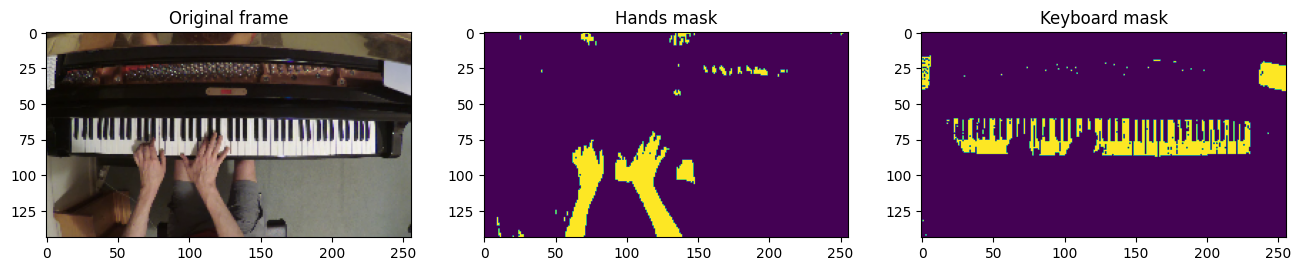

In [23]:
def plot_pairs(data, labels, index=None):
    if index == None:
        index = np.random.randint(0,len(data))
    fig, axes = plt.subplots(1, 3, figsize=(16,4))
    mask = np.squeeze(labels[index])
    axes[0].set_title("Original frame")
    axes[0].imshow(data[index])
    axes[1].set_title("Hands mask")
    axes[1].imshow(mask == 1)
    axes[2].set_title("Keyboard mask")
    axes[2].imshow(mask == 2)
    plt.show()
plot_pairs(X,y)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=seed)

In [14]:
input_shape = X_train.shape[1:]
input_shape

(144, 256, 3)

In [7]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', name=''):
    x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=name+'bn1')(x)
    x = tfkl.Activation(activation, name=name+'activation1')(x)
    x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv2')(x)
    x = tfkl.BatchNormalization(name=name+'bn2')(x)
    x = tfkl.Activation(activation, name=name+'activation2')(x)
    return x

In [15]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First Downsampling
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)
    d1 = tfkl.Dropout(0.2, seed=seed)(d1)

    # Second Downsampling
    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)
    d2 = tfkl.Dropout(0.2, seed=seed)(d2)

    '''
    # Third Downsampling
    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)
    d3 = tfkl.Dropout(0.2, seed=seed)(d3)

    # Forth Downsampling
    down_block_4 = unet_block(d3, 512, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)
    d4 = tfkl.Dropout(0.2, seed=seed)(d4)

    # Bottleneck
    bottleneck = unet_block(d4, 1024)
    '''
    # Bottleneck
    bottleneck = unet_block(d2, 256)

    '''
    # First Upsampling
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Dropout(0.2, seed=seed)(u1)
    u1 = tfkl.Concatenate()([u1,down_block_4])
    u1 = unet_block(u1, 512, name='up_block1_')

    # Second Upsampling
    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Dropout(0.2, seed=seed)(u2)
    u2 = tfkl.Concatenate()([u2,down_block_3])
    u2 = unet_block(u2, 256, name='up_block2_')
    '''

    # Third Upsampling
    u3 = tfkl.UpSampling2D()(bottleneck) #u2)
    u3 = tfkl.Dropout(0.2, seed=seed)(u3)
    u3 = tfkl.Concatenate()([u3,down_block_2])
    u3 = unet_block(u3, 128, name='up_block3_')

    # Forth Upsampling
    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Dropout(0.2, seed=seed)(u4)
    u4 = tfkl.Concatenate()([u4,down_block_1])
    u4 = unet_block(u4, 64, name='up_block4_')

    # Output Layer
    output_layer = tf.keras.layers.Conv2D(num_classes, kernel_size=3, padding='same', activation="softmax", name='output_layer')(u4)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [17]:
import visualkeras

model = get_unet_model()
model.summary()
visualkeras.layered_view(model, legend=True, spacing=50, scale_xy=10)
tf.keras.utils.plot_model(model, show_shapes = True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 down_block1_conv1 (Conv2D)     (None, 144, 256, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 down_block1_bn1 (BatchNormaliz  (None, 144, 256, 64  256        ['down_block1_conv1[0][0]']      
 ation)                         )                                                             

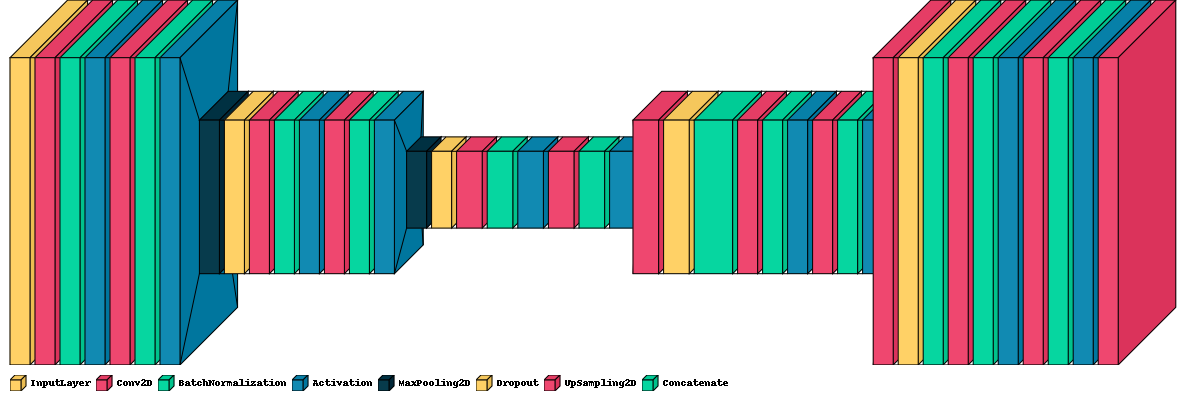

In [46]:
visualkeras.layered_view(model, legend=True, spacing=5, scale_xy=1.2)

In [48]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "num_classes": self.num_classes}

class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label
    
    def on_epoch_end(self, epoch, logs=None):
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (144, 256, 1))
        fig, axes = plt.subplots(1, 2, figsize=(16,4))
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Original Mask")
        axes[1].imshow(np.squeeze(y_pred))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [49]:
learning_rate = 1e-3
batch_size = 4
epochs = 1000
model.compile(
    loss = "sparse_categorical_crossentropy", 
    optimizer = tfk.optimizers.Adam(learning_rate), 
    metrics = [
        "accuracy", 
        UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")
        ]
    )

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience = 10, restore_best_weights = True)
viz_callback = VizCallback(np.expand_dims(X_val[0],axis=0), np.expand_dims(y_val[0],axis=0))

Epoch 1/1000
60/60 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9699 - mean_iou: 0.8155

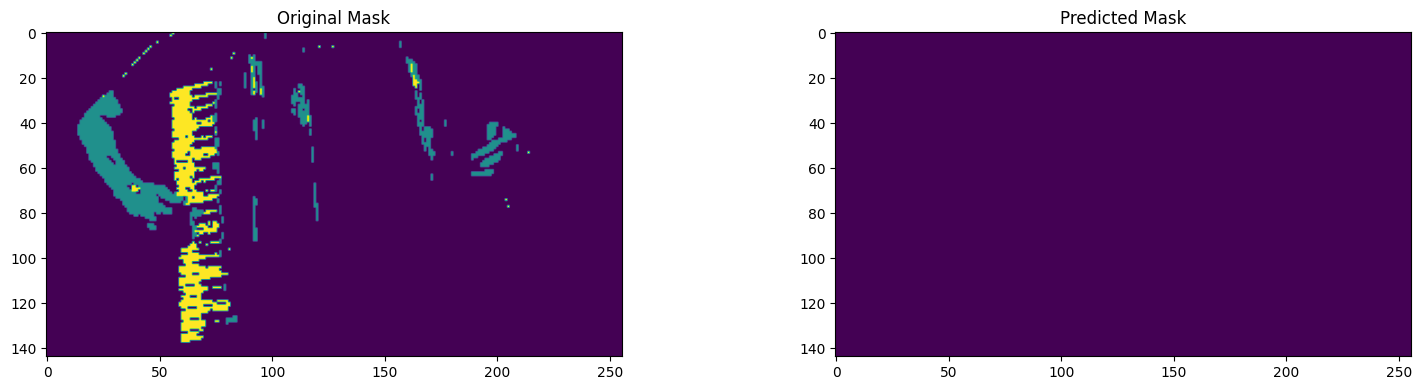

60/60 [==============================] - 48s 758ms/step - loss: 0.0862 - accuracy: 0.9699 - mean_iou: 0.8155 - val_loss: 1.0141 - val_accuracy: 0.8757 - val_mean_iou: 0.3121
Epoch 2/1000
60/60 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9782 - mean_iou: 0.8660

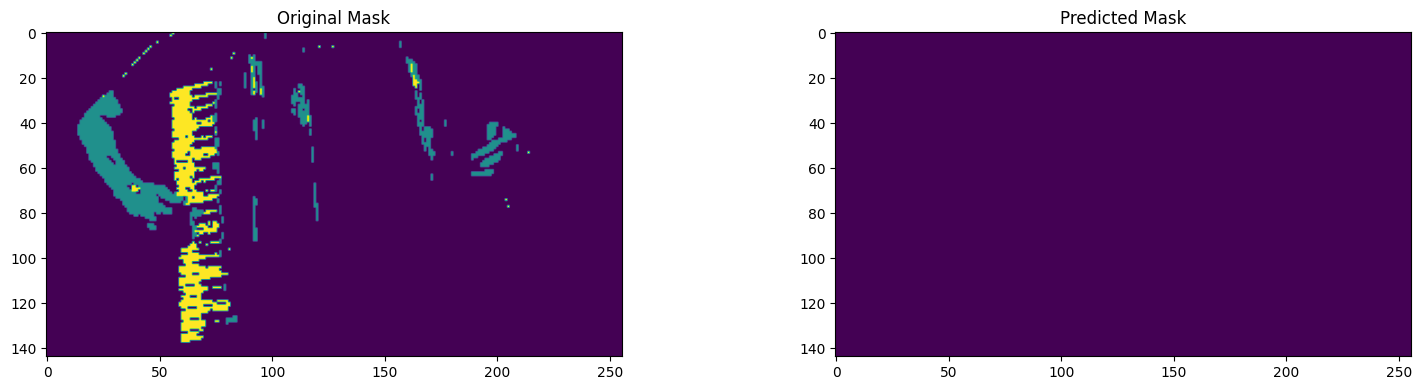

60/60 [==============================] - 42s 693ms/step - loss: 0.0609 - accuracy: 0.9782 - mean_iou: 0.8660 - val_loss: 1.2799 - val_accuracy: 0.8731 - val_mean_iou: 0.2910
Epoch 3/1000
60/60 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9835 - mean_iou: 0.8958

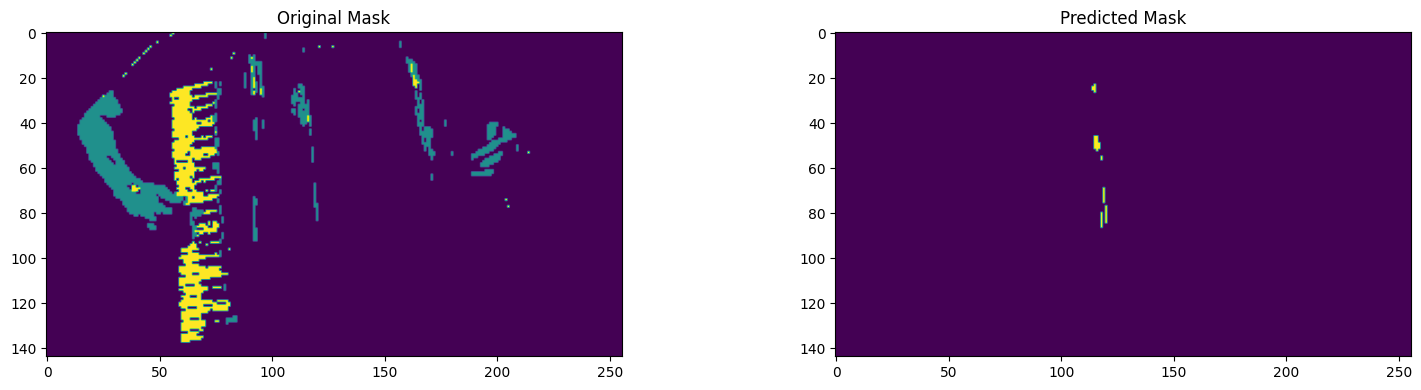

60/60 [==============================] - 42s 700ms/step - loss: 0.0457 - accuracy: 0.9835 - mean_iou: 0.8958 - val_loss: 1.3512 - val_accuracy: 0.8765 - val_mean_iou: 0.3192
Epoch 4/1000
60/60 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9846 - mean_iou: 0.9026

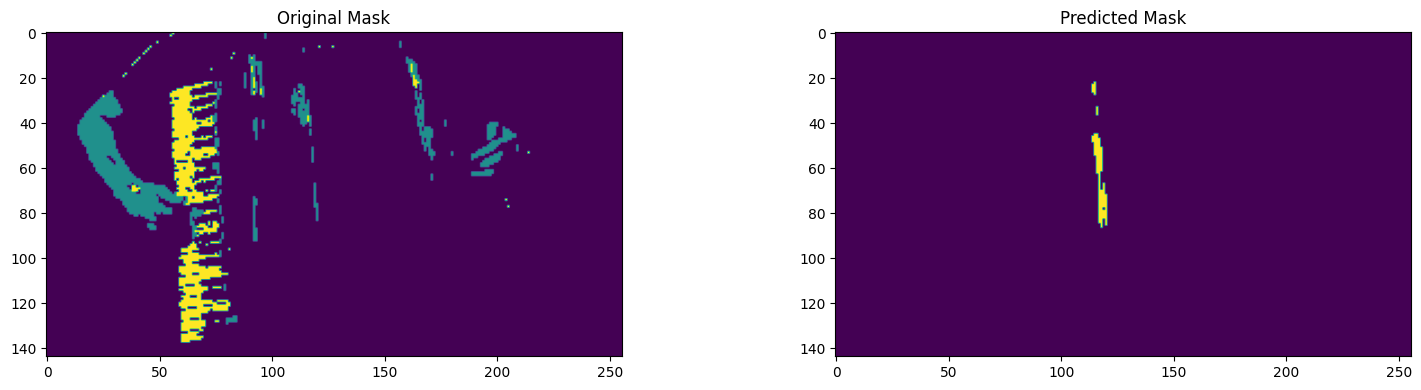

60/60 [==============================] - 42s 703ms/step - loss: 0.0419 - accuracy: 0.9846 - mean_iou: 0.9026 - val_loss: 1.1499 - val_accuracy: 0.8778 - val_mean_iou: 0.3309
Epoch 5/1000
60/60 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9820 - mean_iou: 0.8888

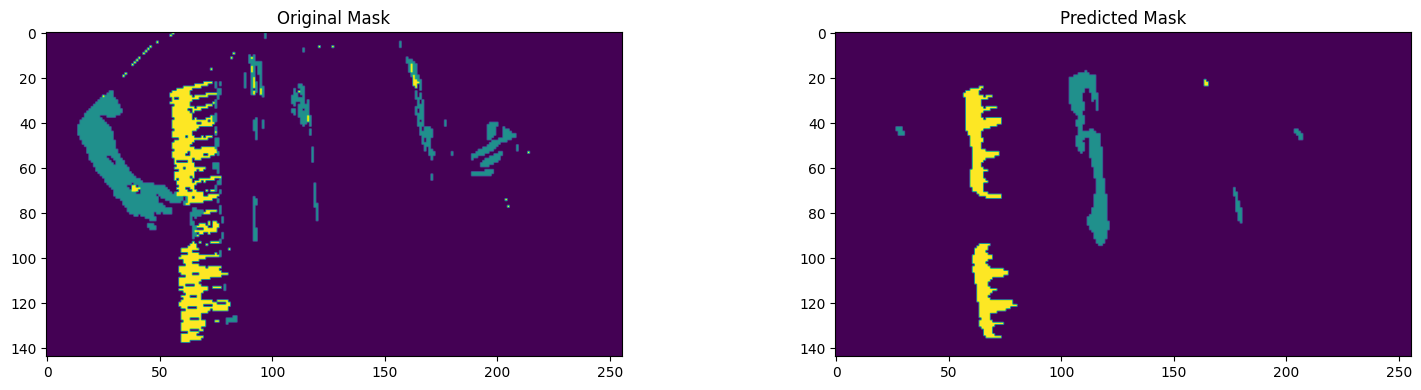

60/60 [==============================] - 42s 701ms/step - loss: 0.0487 - accuracy: 0.9820 - mean_iou: 0.8888 - val_loss: 0.1962 - val_accuracy: 0.9519 - val_mean_iou: 0.6900
Epoch 6/1000
60/60 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9858 - mean_iou: 0.9095

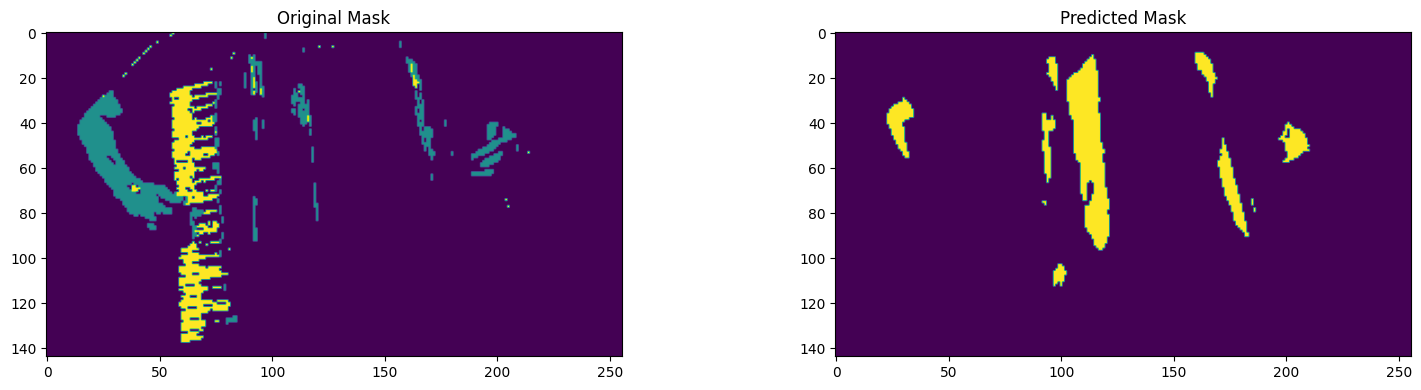

60/60 [==============================] - 42s 704ms/step - loss: 0.0385 - accuracy: 0.9858 - mean_iou: 0.9095 - val_loss: 0.4523 - val_accuracy: 0.8894 - val_mean_iou: 0.4311
Epoch 7/1000
60/60 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9863 - mean_iou: 0.9115

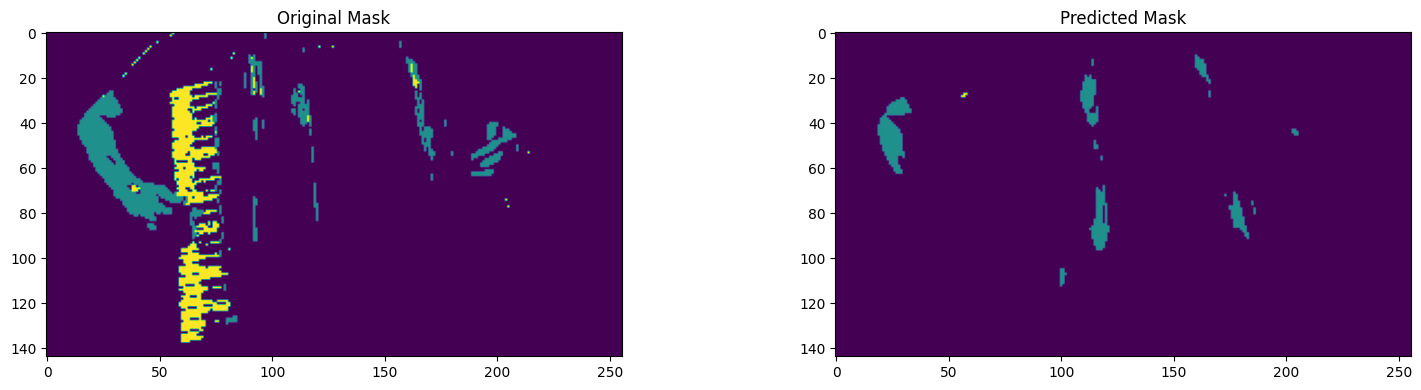

60/60 [==============================] - 42s 704ms/step - loss: 0.0364 - accuracy: 0.9863 - mean_iou: 0.9115 - val_loss: 0.2591 - val_accuracy: 0.9227 - val_mean_iou: 0.6006
Epoch 8/1000
60/60 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9880 - mean_iou: 0.9226

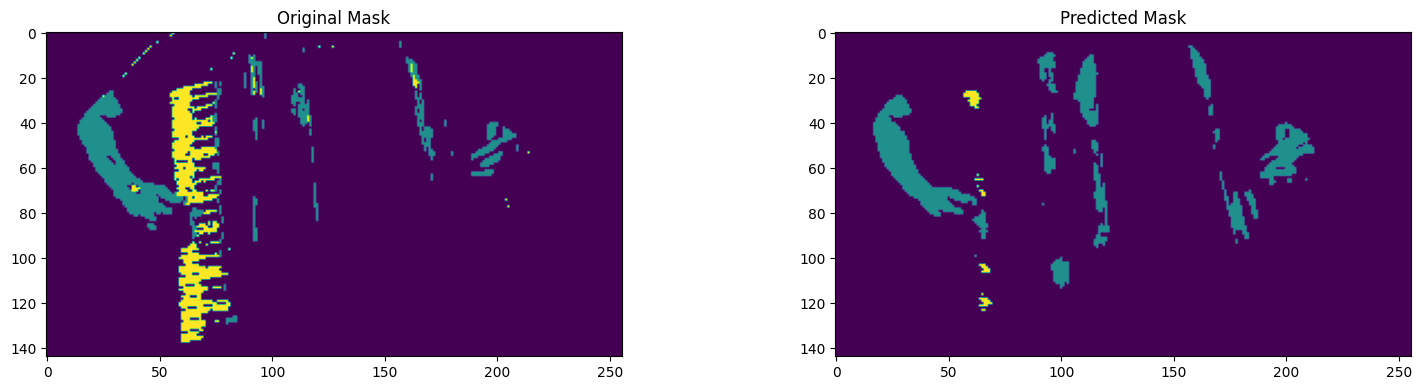

60/60 [==============================] - 42s 707ms/step - loss: 0.0316 - accuracy: 0.9880 - mean_iou: 0.9226 - val_loss: 0.1479 - val_accuracy: 0.9497 - val_mean_iou: 0.7443
Epoch 9/1000
60/60 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9881 - mean_iou: 0.9235

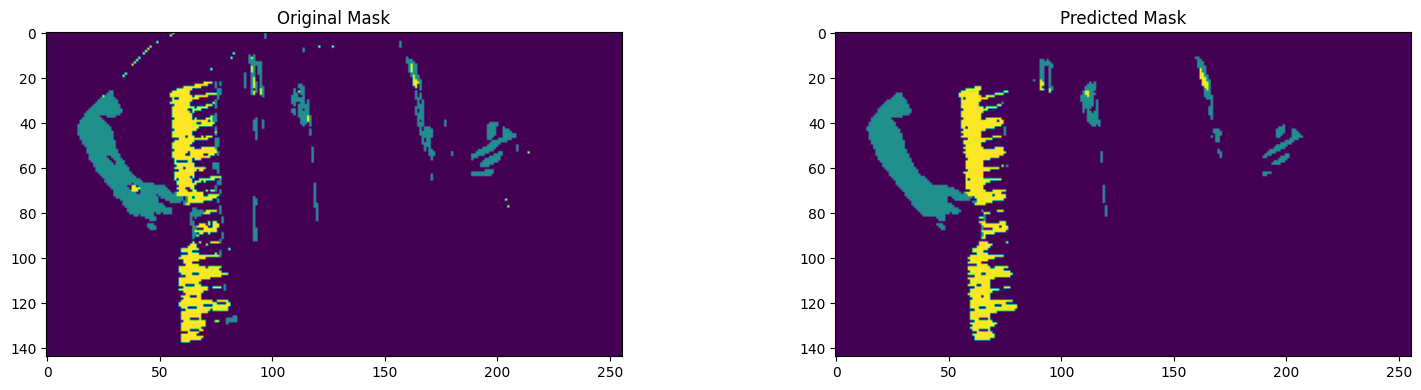

60/60 [==============================] - 43s 710ms/step - loss: 0.0315 - accuracy: 0.9881 - mean_iou: 0.9235 - val_loss: 0.0465 - val_accuracy: 0.9816 - val_mean_iou: 0.8938
Epoch 10/1000
60/60 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9889 - mean_iou: 0.9279

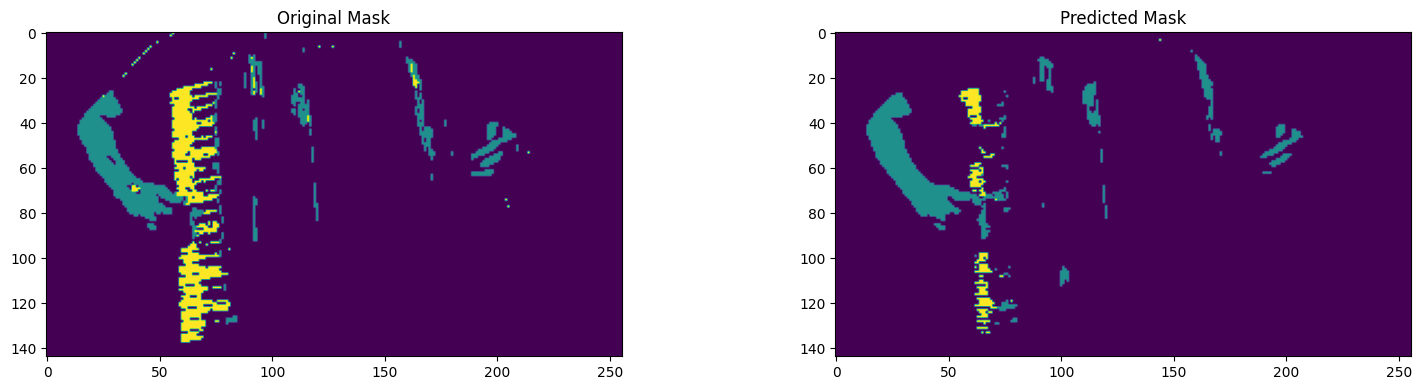

60/60 [==============================] - 43s 710ms/step - loss: 0.0293 - accuracy: 0.9889 - mean_iou: 0.9279 - val_loss: 0.0414 - val_accuracy: 0.9846 - val_mean_iou: 0.9118
Epoch 11/1000
60/60 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9895 - mean_iou: 0.9318

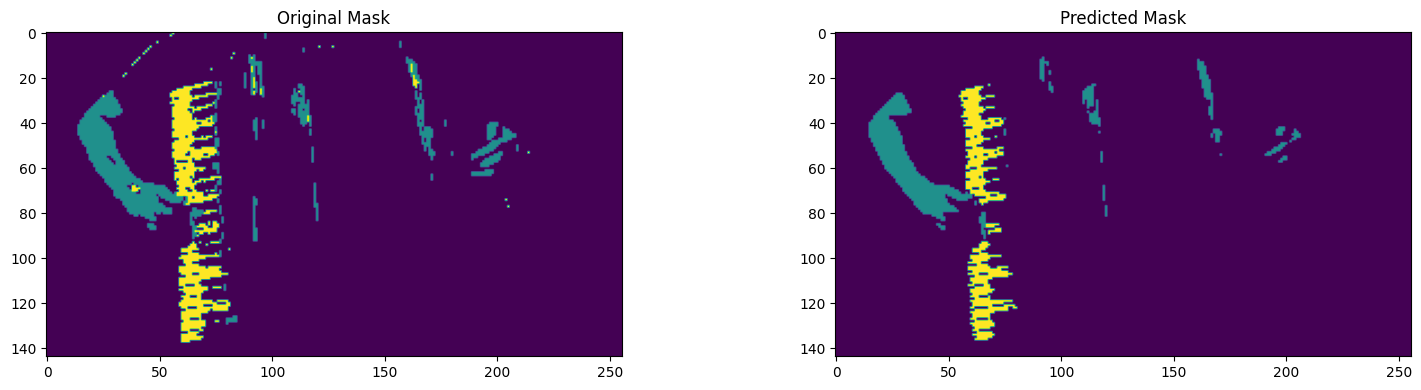

60/60 [==============================] - 43s 712ms/step - loss: 0.0273 - accuracy: 0.9895 - mean_iou: 0.9318 - val_loss: 0.0427 - val_accuracy: 0.9838 - val_mean_iou: 0.9033
Epoch 12/1000
60/60 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9900 - mean_iou: 0.9347

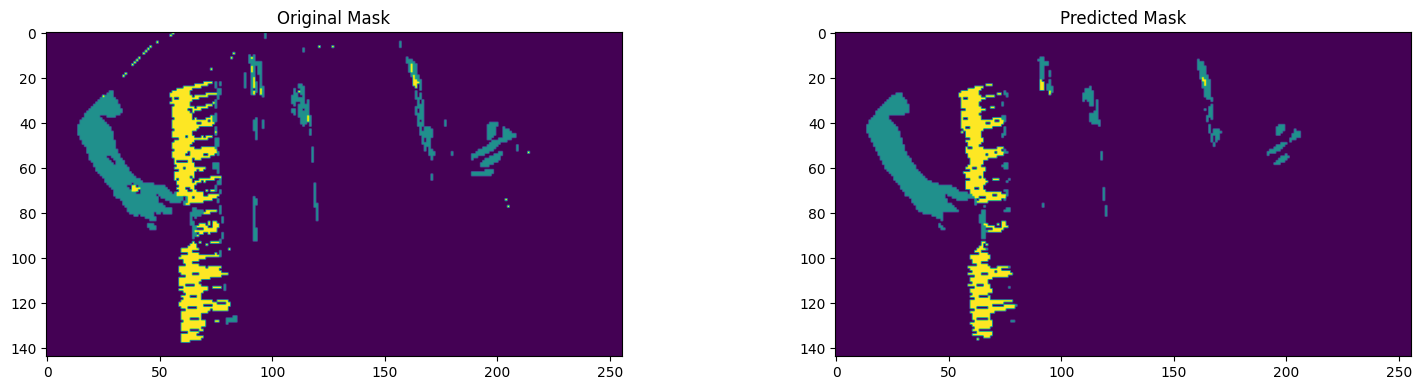

60/60 [==============================] - 43s 713ms/step - loss: 0.0261 - accuracy: 0.9900 - mean_iou: 0.9347 - val_loss: 0.0345 - val_accuracy: 0.9864 - val_mean_iou: 0.9184
Epoch 13/1000
60/60 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9903 - mean_iou: 0.9372

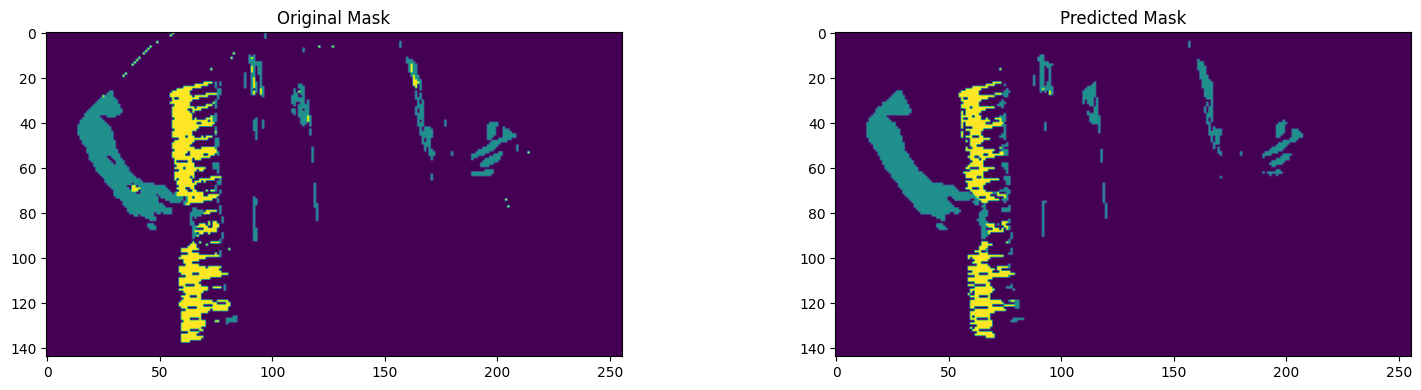

60/60 [==============================] - 43s 717ms/step - loss: 0.0251 - accuracy: 0.9903 - mean_iou: 0.9372 - val_loss: 0.0281 - val_accuracy: 0.9894 - val_mean_iou: 0.9340
Epoch 14/1000
60/60 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9902 - mean_iou: 0.9363

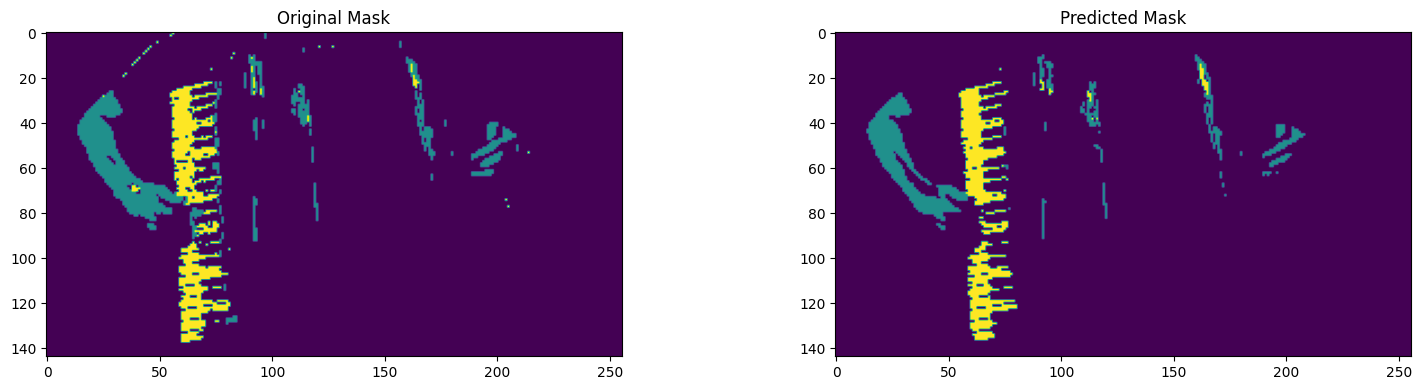

60/60 [==============================] - 43s 714ms/step - loss: 0.0253 - accuracy: 0.9902 - mean_iou: 0.9363 - val_loss: 0.0368 - val_accuracy: 0.9859 - val_mean_iou: 0.9116
Epoch 15/1000
60/60 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9882 - mean_iou: 0.9229

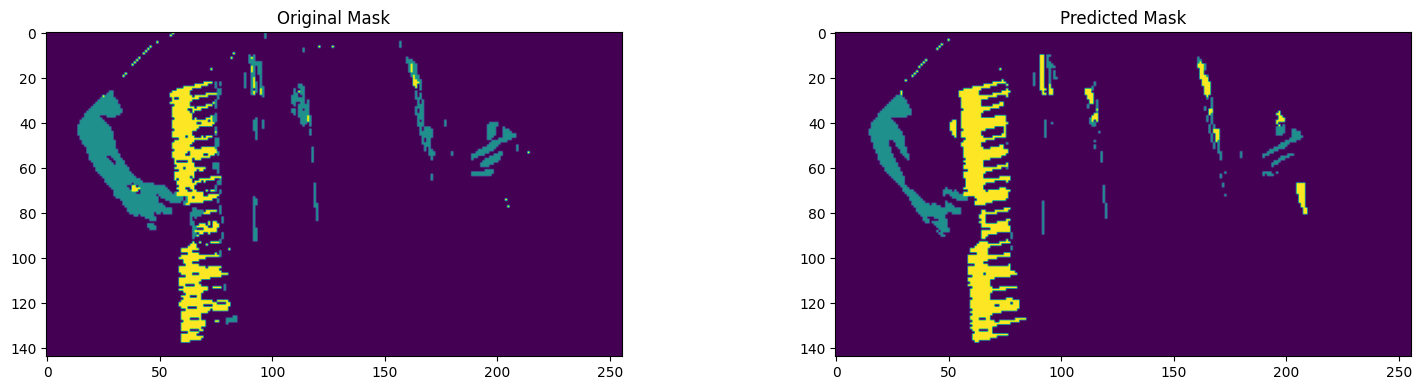

60/60 [==============================] - 43s 715ms/step - loss: 0.0313 - accuracy: 0.9882 - mean_iou: 0.9229 - val_loss: 0.0695 - val_accuracy: 0.9764 - val_mean_iou: 0.8350
Epoch 16/1000
60/60 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9888 - mean_iou: 0.9263

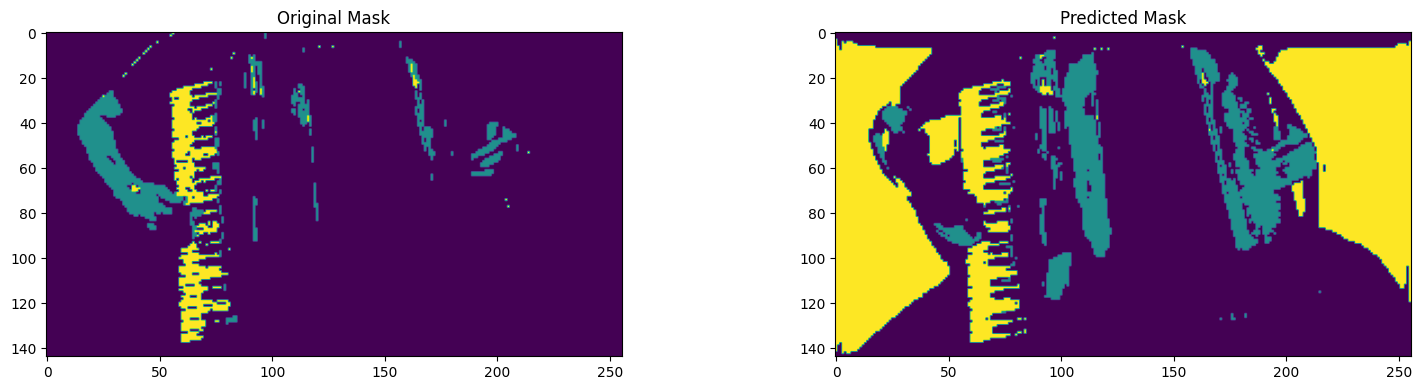

60/60 [==============================] - 43s 717ms/step - loss: 0.0297 - accuracy: 0.9888 - mean_iou: 0.9263 - val_loss: 0.5292 - val_accuracy: 0.8390 - val_mean_iou: 0.5454
Epoch 17/1000
60/60 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9857 - mean_iou: 0.9076

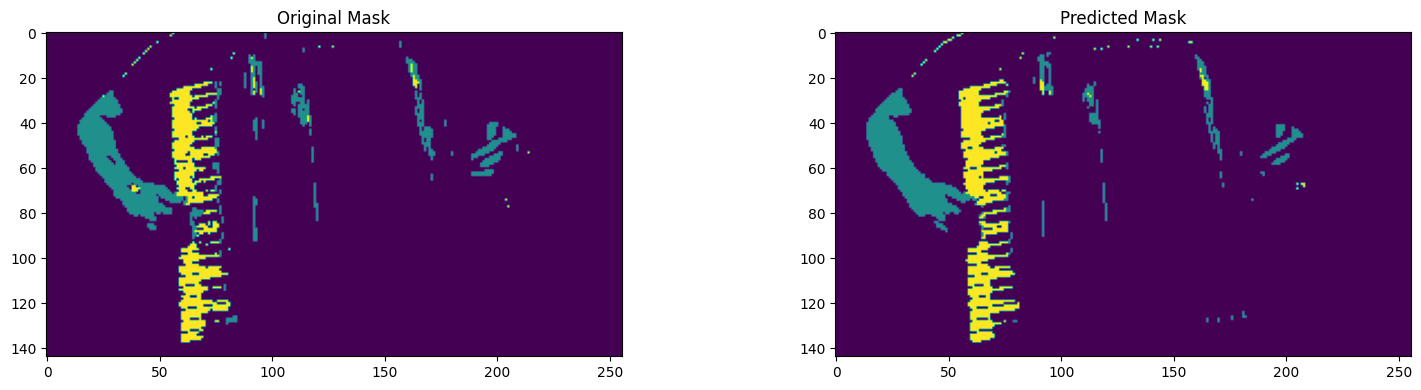

60/60 [==============================] - 43s 717ms/step - loss: 0.0380 - accuracy: 0.9857 - mean_iou: 0.9076 - val_loss: 0.0309 - val_accuracy: 0.9885 - val_mean_iou: 0.9303
Epoch 18/1000
60/60 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9900 - mean_iou: 0.9348

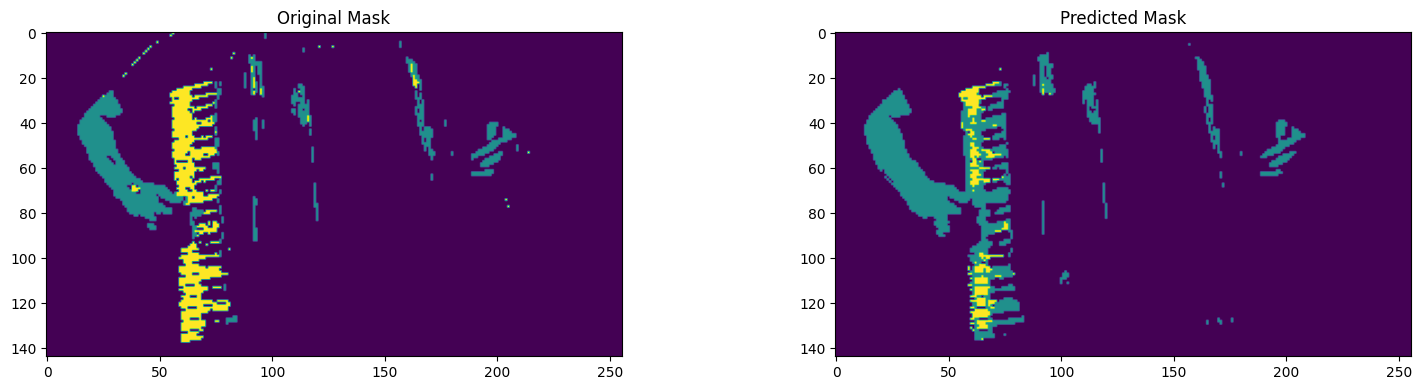

60/60 [==============================] - 44s 724ms/step - loss: 0.0260 - accuracy: 0.9900 - mean_iou: 0.9348 - val_loss: 0.0400 - val_accuracy: 0.9845 - val_mean_iou: 0.8930
Epoch 19/1000
60/60 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9907 - mean_iou: 0.9396

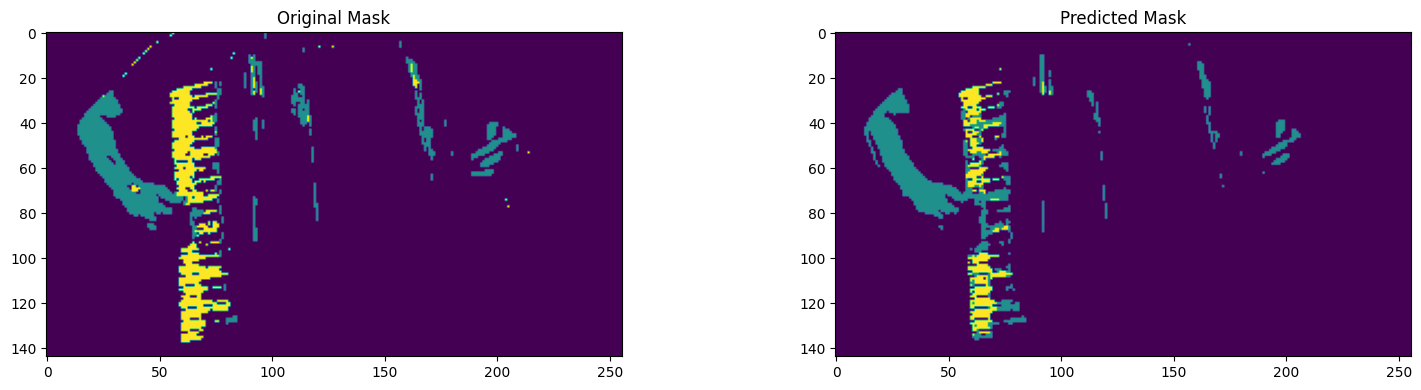

60/60 [==============================] - 44s 726ms/step - loss: 0.0240 - accuracy: 0.9907 - mean_iou: 0.9396 - val_loss: 0.0378 - val_accuracy: 0.9859 - val_mean_iou: 0.9082
Epoch 20/1000
60/60 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9912 - mean_iou: 0.9424

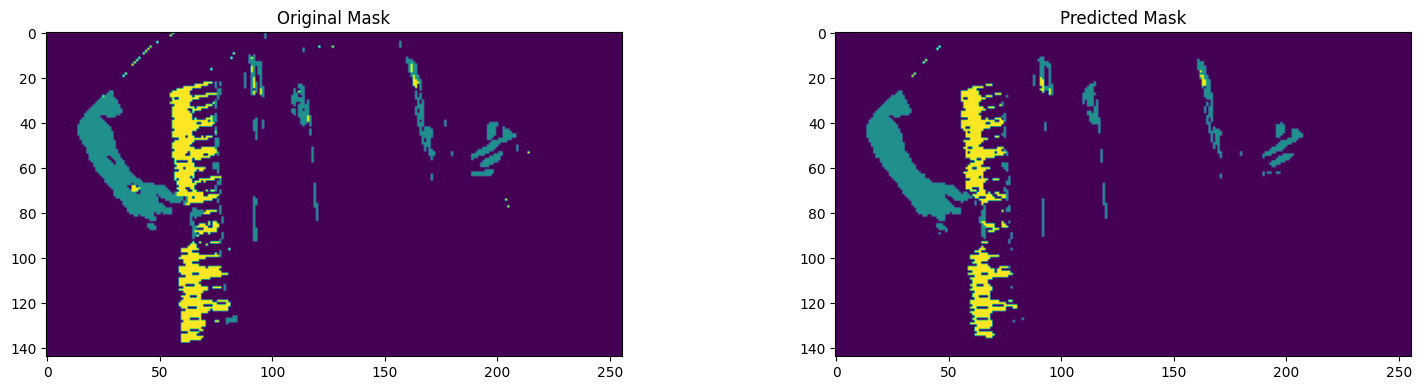

60/60 [==============================] - 43s 720ms/step - loss: 0.0227 - accuracy: 0.9912 - mean_iou: 0.9424 - val_loss: 0.0305 - val_accuracy: 0.9879 - val_mean_iou: 0.9281
Epoch 21/1000
60/60 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9912 - mean_iou: 0.9426

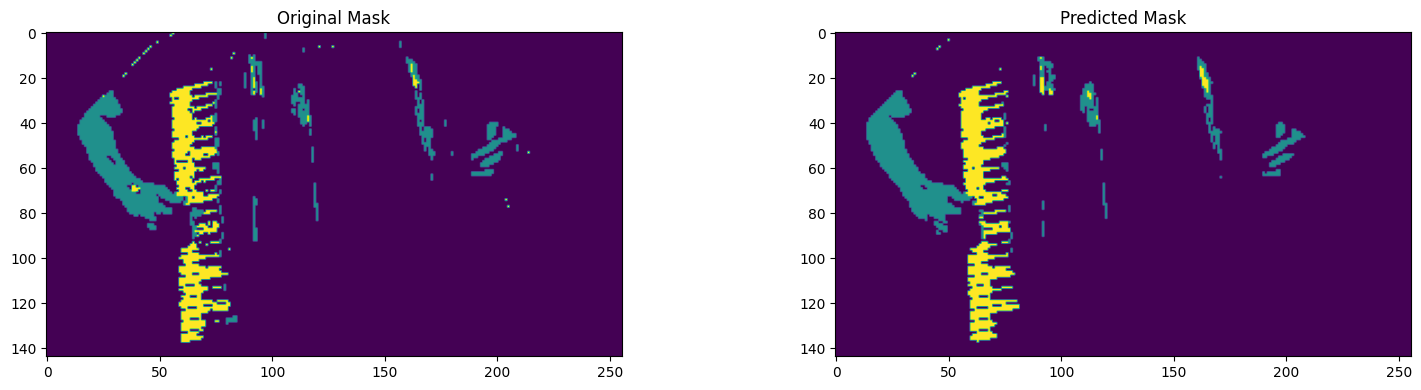

60/60 [==============================] - 43s 718ms/step - loss: 0.0225 - accuracy: 0.9912 - mean_iou: 0.9426 - val_loss: 0.0232 - val_accuracy: 0.9910 - val_mean_iou: 0.9445
Epoch 22/1000
60/60 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9915 - mean_iou: 0.9443

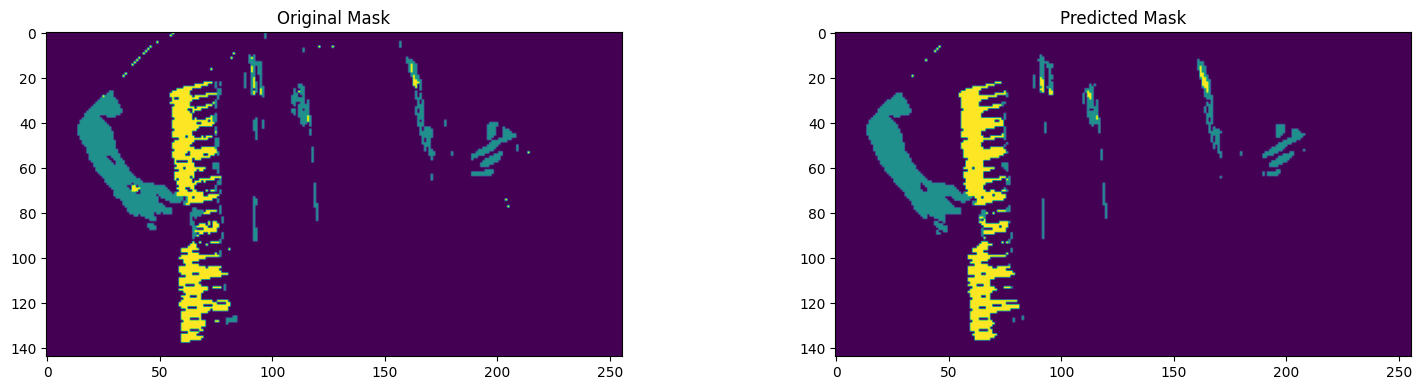

60/60 [==============================] - 43s 718ms/step - loss: 0.0219 - accuracy: 0.9915 - mean_iou: 0.9443 - val_loss: 0.0231 - val_accuracy: 0.9911 - val_mean_iou: 0.9455
Epoch 23/1000
60/60 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9916 - mean_iou: 0.9451

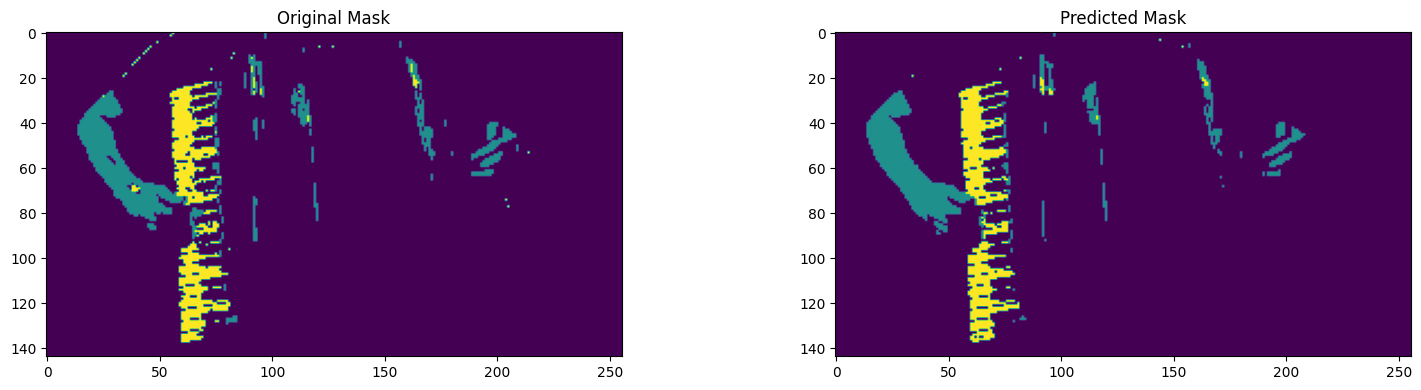

60/60 [==============================] - 43s 716ms/step - loss: 0.0214 - accuracy: 0.9916 - mean_iou: 0.9451 - val_loss: 0.0214 - val_accuracy: 0.9917 - val_mean_iou: 0.9484
Epoch 24/1000
60/60 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9918 - mean_iou: 0.9466

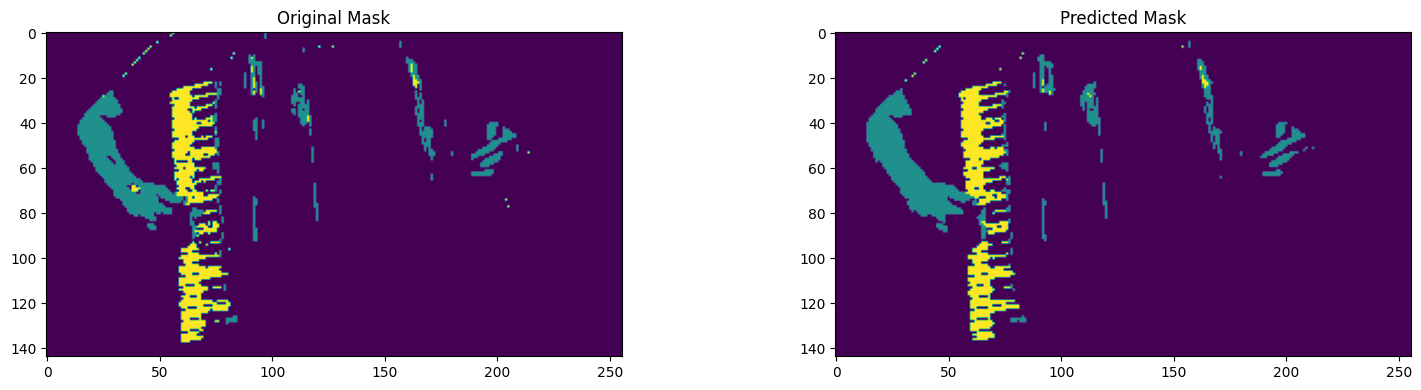

60/60 [==============================] - 43s 718ms/step - loss: 0.0208 - accuracy: 0.9918 - mean_iou: 0.9466 - val_loss: 0.0240 - val_accuracy: 0.9906 - val_mean_iou: 0.9400
Epoch 25/1000
60/60 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9917 - mean_iou: 0.9453

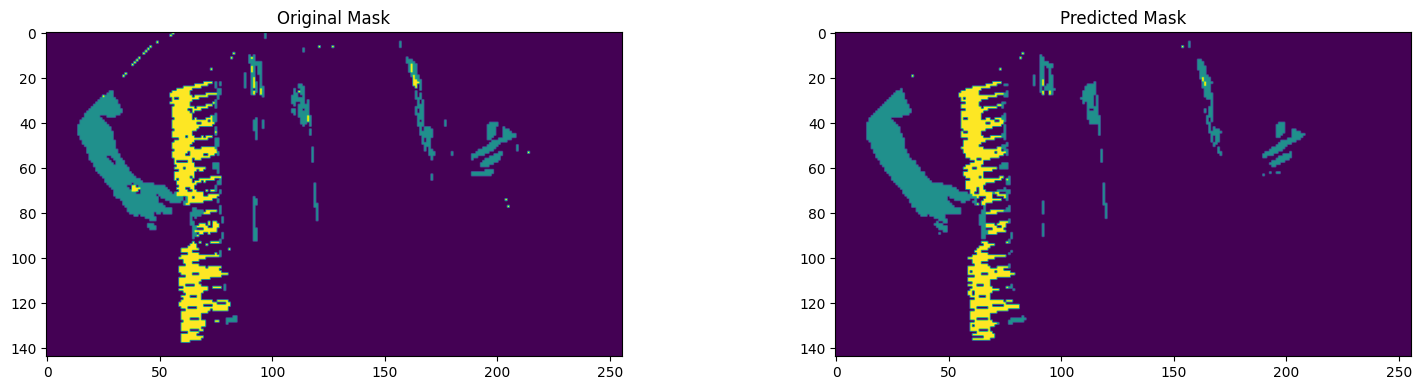

60/60 [==============================] - 43s 716ms/step - loss: 0.0212 - accuracy: 0.9917 - mean_iou: 0.9453 - val_loss: 0.0225 - val_accuracy: 0.9912 - val_mean_iou: 0.9455
Epoch 26/1000
60/60 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9919 - mean_iou: 0.9471

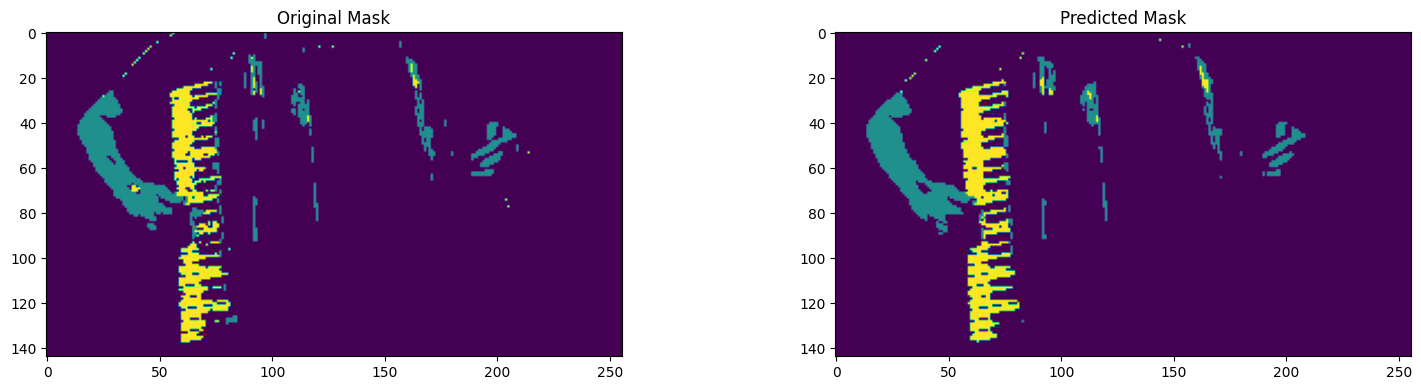

60/60 [==============================] - 44s 737ms/step - loss: 0.0205 - accuracy: 0.9919 - mean_iou: 0.9471 - val_loss: 0.0215 - val_accuracy: 0.9916 - val_mean_iou: 0.9491
Epoch 27/1000
60/60 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9914 - mean_iou: 0.9440

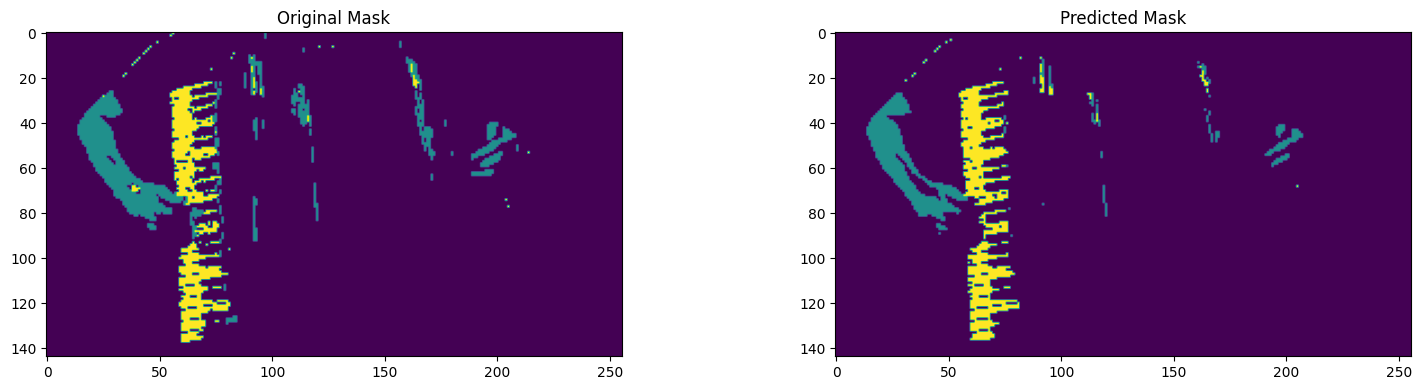

60/60 [==============================] - 44s 735ms/step - loss: 0.0217 - accuracy: 0.9914 - mean_iou: 0.9440 - val_loss: 0.0287 - val_accuracy: 0.9892 - val_mean_iou: 0.9319
Epoch 28/1000
60/60 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9916 - mean_iou: 0.9449

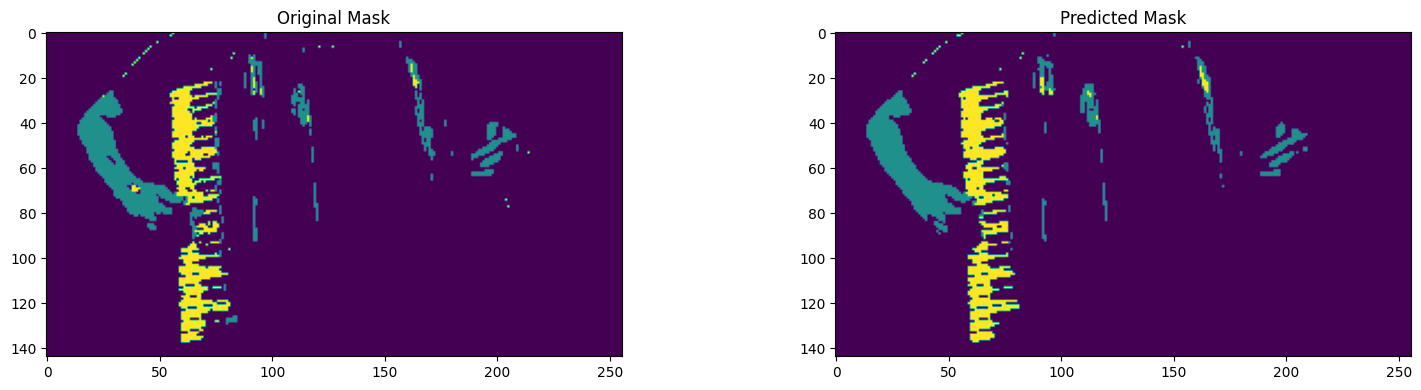

60/60 [==============================] - 44s 738ms/step - loss: 0.0213 - accuracy: 0.9916 - mean_iou: 0.9449 - val_loss: 0.0209 - val_accuracy: 0.9918 - val_mean_iou: 0.9491
Epoch 29/1000
60/60 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9923 - mean_iou: 0.9500

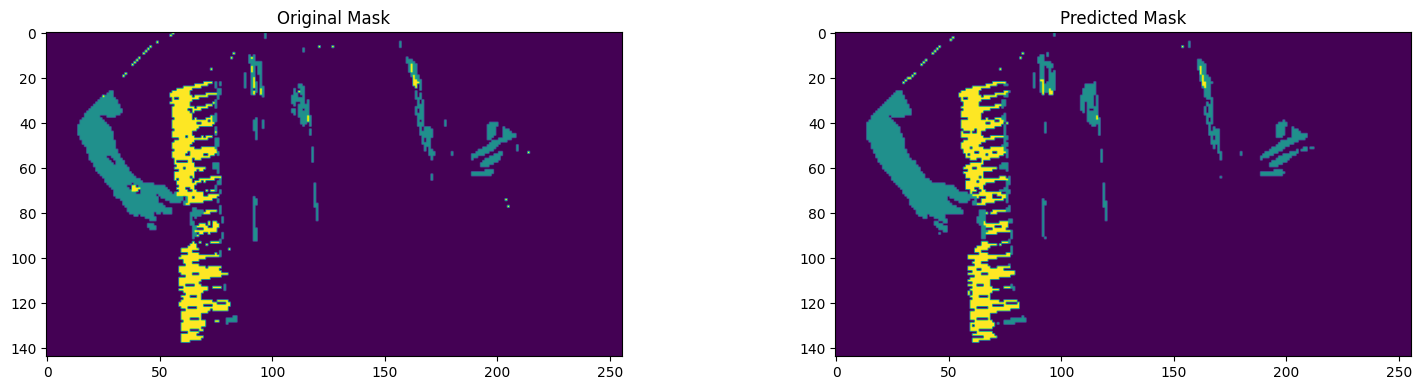

60/60 [==============================] - 44s 738ms/step - loss: 0.0194 - accuracy: 0.9923 - mean_iou: 0.9500 - val_loss: 0.0202 - val_accuracy: 0.9922 - val_mean_iou: 0.9520
Epoch 30/1000
60/60 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9927 - mean_iou: 0.9522

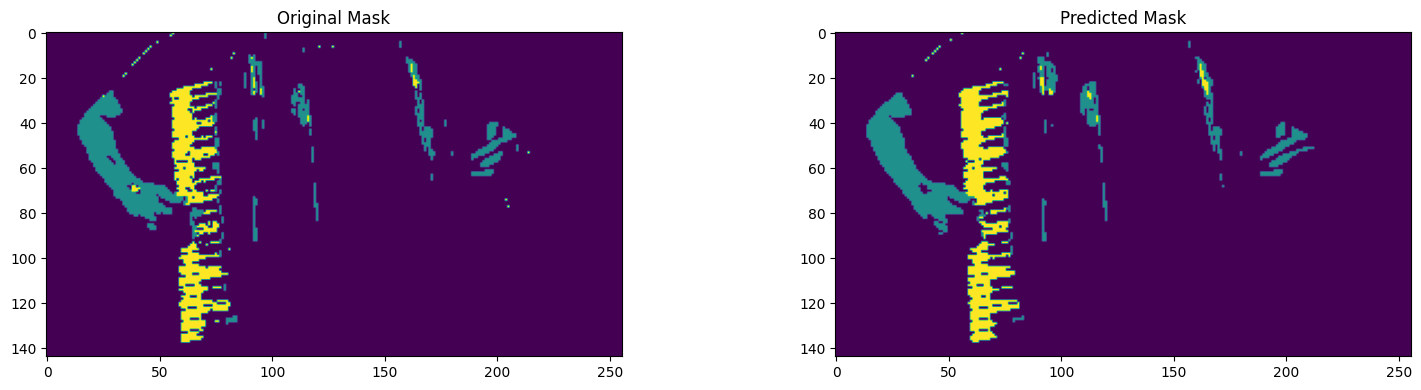

60/60 [==============================] - 44s 738ms/step - loss: 0.0185 - accuracy: 0.9927 - mean_iou: 0.9522 - val_loss: 0.0194 - val_accuracy: 0.9922 - val_mean_iou: 0.9513
Epoch 31/1000
60/60 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9926 - mean_iou: 0.9516

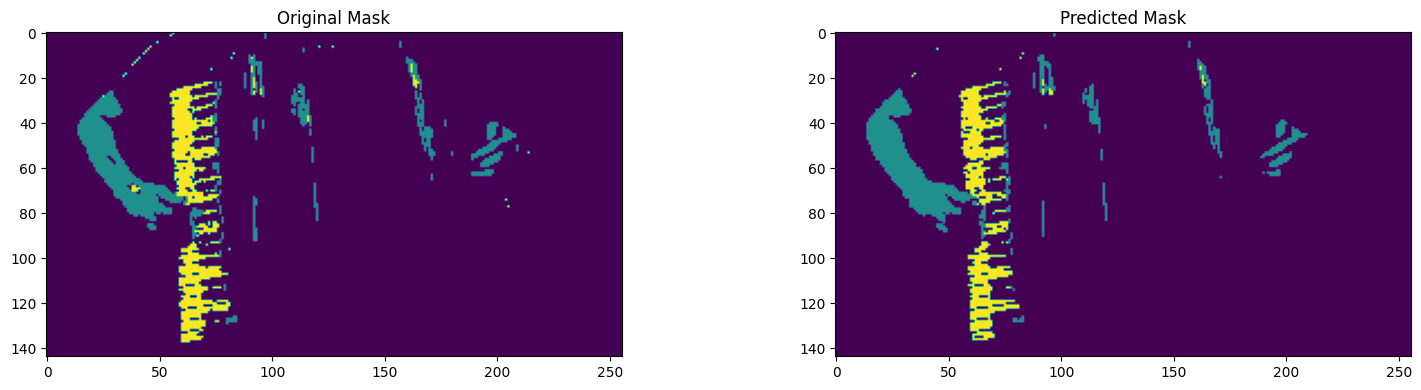

60/60 [==============================] - 44s 735ms/step - loss: 0.0186 - accuracy: 0.9926 - mean_iou: 0.9516 - val_loss: 0.0257 - val_accuracy: 0.9900 - val_mean_iou: 0.9401
Epoch 32/1000
60/60 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9924 - mean_iou: 0.9501

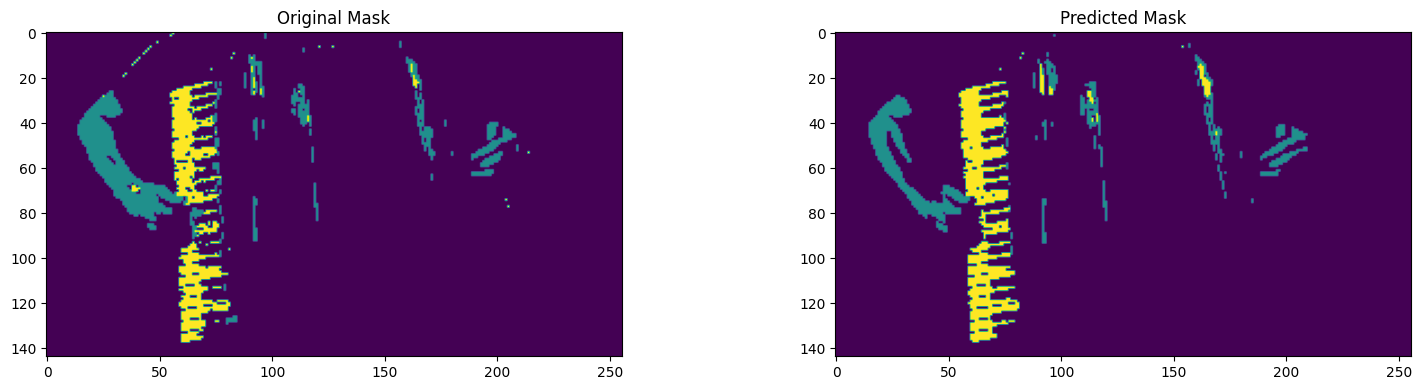

60/60 [==============================] - 45s 744ms/step - loss: 0.0192 - accuracy: 0.9924 - mean_iou: 0.9501 - val_loss: 0.0306 - val_accuracy: 0.9886 - val_mean_iou: 0.9303
Epoch 33/1000
60/60 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9920 - mean_iou: 0.9479

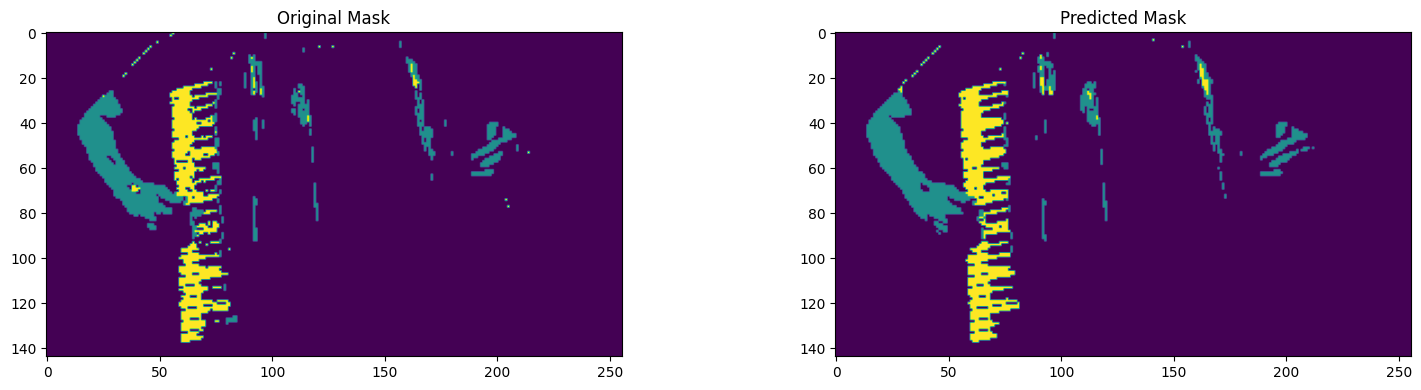

60/60 [==============================] - 45s 741ms/step - loss: 0.0202 - accuracy: 0.9920 - mean_iou: 0.9479 - val_loss: 0.0195 - val_accuracy: 0.9924 - val_mean_iou: 0.9534
Epoch 34/1000
60/60 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9925 - mean_iou: 0.9512

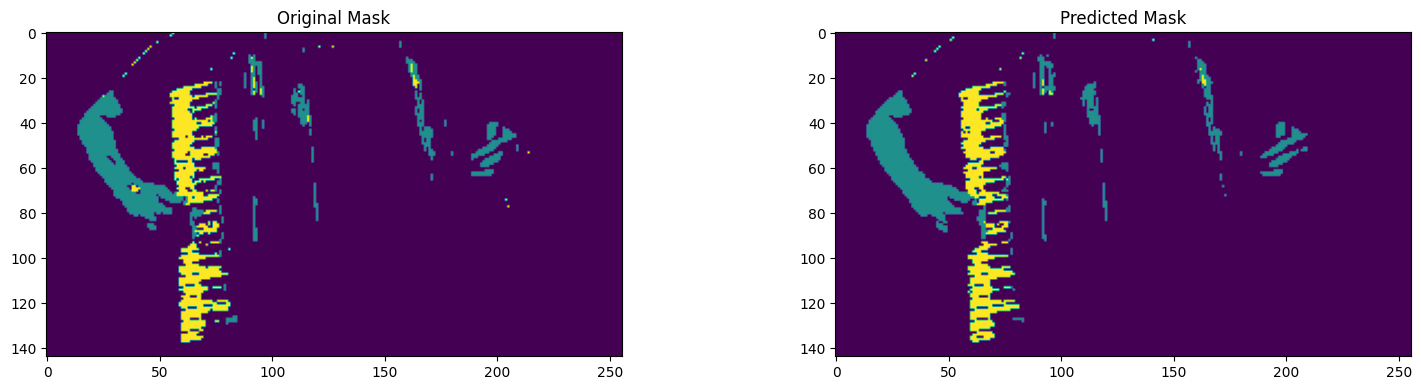

60/60 [==============================] - 44s 739ms/step - loss: 0.0189 - accuracy: 0.9925 - mean_iou: 0.9512 - val_loss: 0.0190 - val_accuracy: 0.9926 - val_mean_iou: 0.9543
Epoch 35/1000
60/60 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9929 - mean_iou: 0.9540

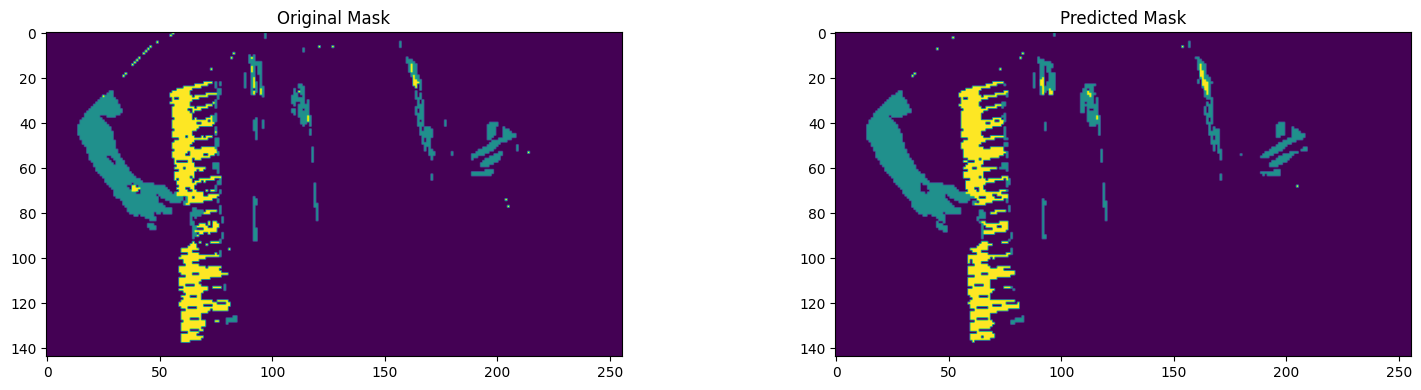

60/60 [==============================] - 44s 738ms/step - loss: 0.0177 - accuracy: 0.9929 - mean_iou: 0.9540 - val_loss: 0.0181 - val_accuracy: 0.9929 - val_mean_iou: 0.9561
Epoch 36/1000
60/60 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9923 - mean_iou: 0.9496

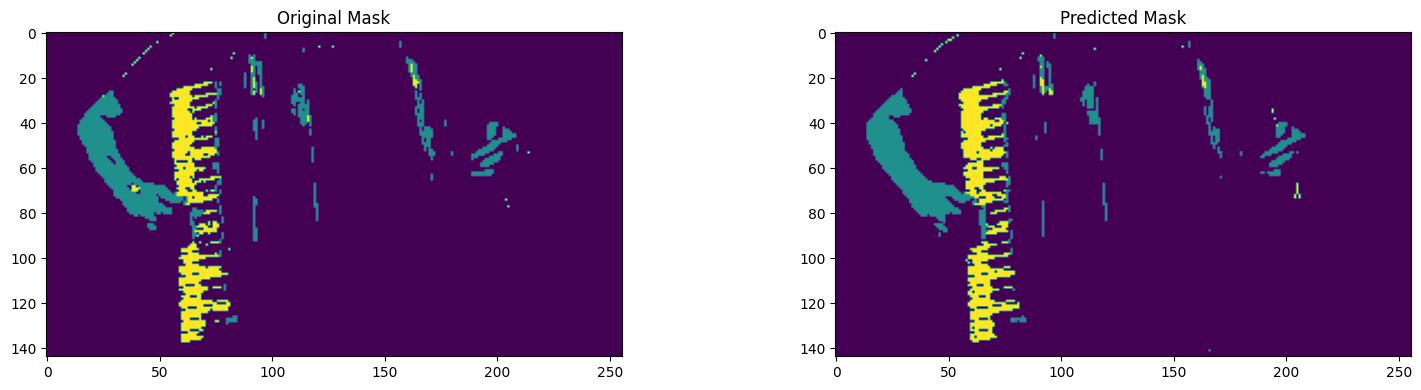

60/60 [==============================] - 44s 738ms/step - loss: 0.0193 - accuracy: 0.9923 - mean_iou: 0.9496 - val_loss: 0.0220 - val_accuracy: 0.9914 - val_mean_iou: 0.9486
Epoch 37/1000
60/60 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9929 - mean_iou: 0.9533

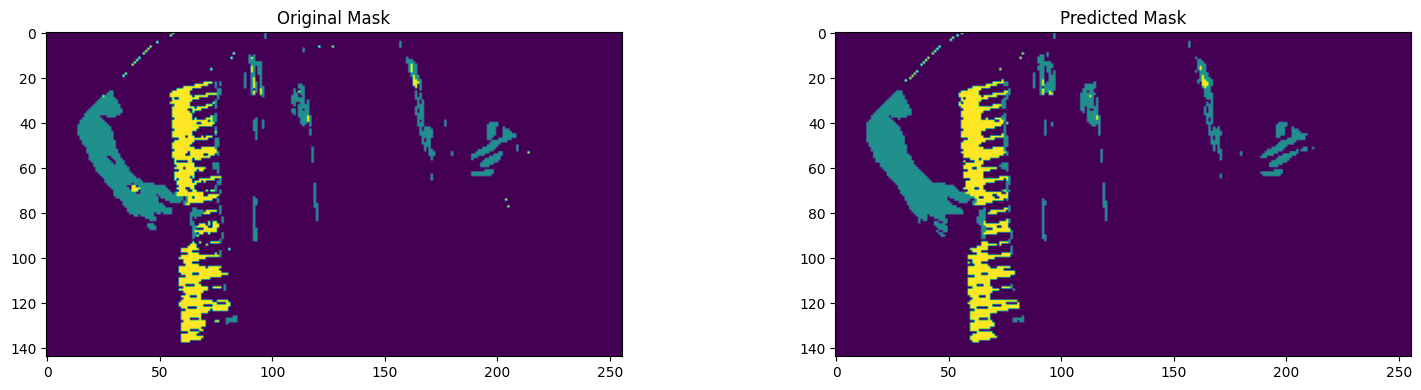

60/60 [==============================] - 44s 739ms/step - loss: 0.0179 - accuracy: 0.9929 - mean_iou: 0.9533 - val_loss: 0.0189 - val_accuracy: 0.9925 - val_mean_iou: 0.9536
Epoch 38/1000
60/60 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9925 - mean_iou: 0.9505

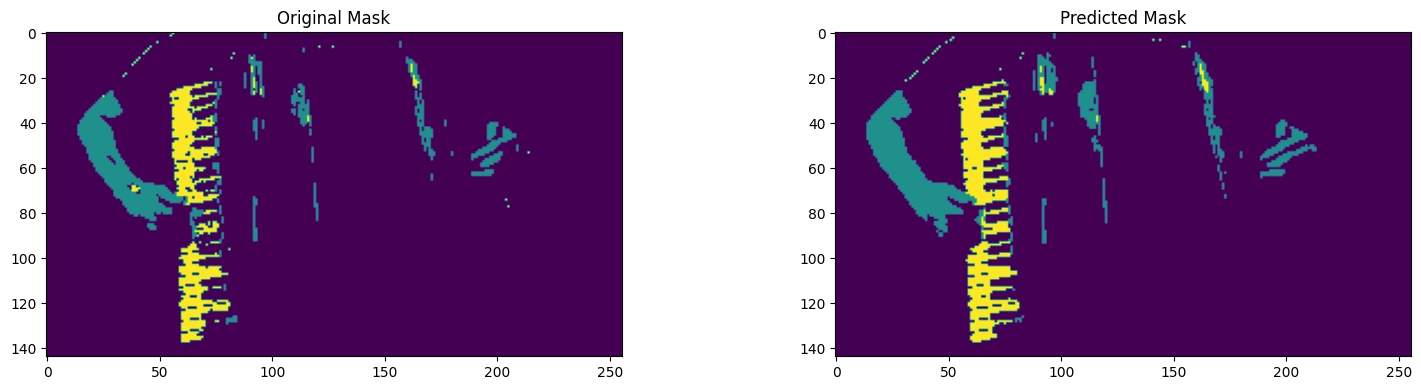

60/60 [==============================] - 45s 743ms/step - loss: 0.0189 - accuracy: 0.9925 - mean_iou: 0.9505 - val_loss: 0.0203 - val_accuracy: 0.9920 - val_mean_iou: 0.9507
Epoch 39/1000
60/60 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9928 - mean_iou: 0.9529

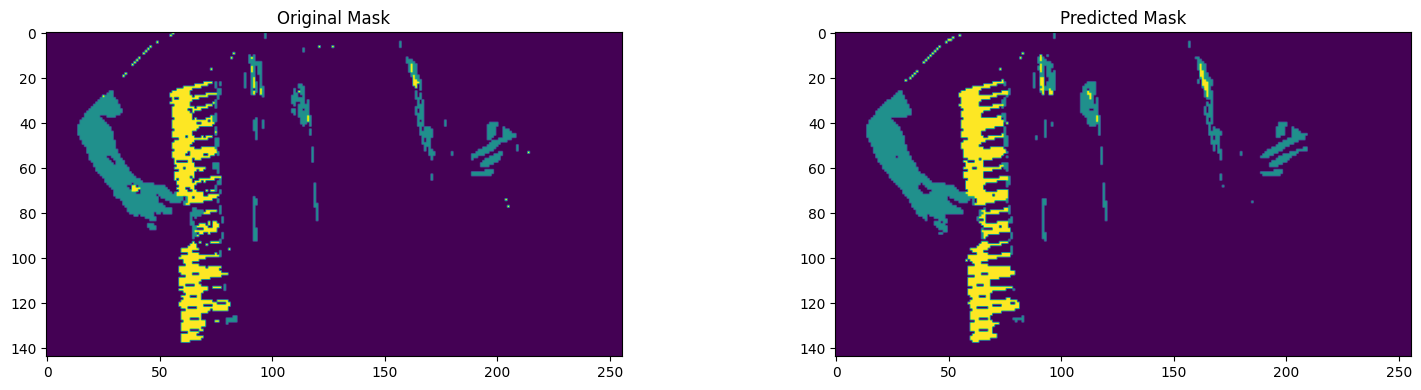

60/60 [==============================] - 44s 738ms/step - loss: 0.0181 - accuracy: 0.9928 - mean_iou: 0.9529 - val_loss: 0.0182 - val_accuracy: 0.9927 - val_mean_iou: 0.9556
Epoch 40/1000
60/60 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9930 - mean_iou: 0.9544

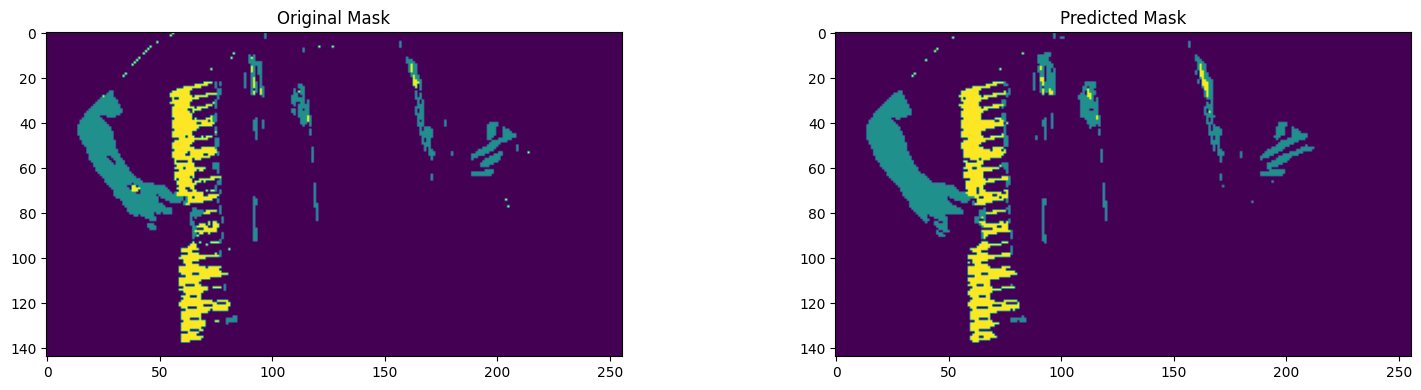

60/60 [==============================] - 45s 743ms/step - loss: 0.0173 - accuracy: 0.9930 - mean_iou: 0.9544 - val_loss: 0.0207 - val_accuracy: 0.9917 - val_mean_iou: 0.9480
Epoch 41/1000
60/60 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9930 - mean_iou: 0.9543

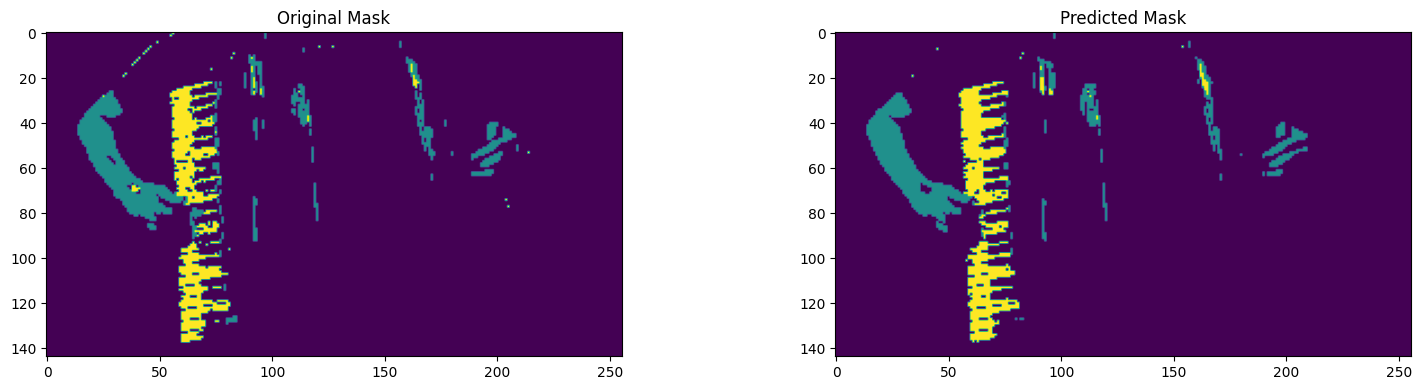

60/60 [==============================] - 45s 741ms/step - loss: 0.0174 - accuracy: 0.9930 - mean_iou: 0.9543 - val_loss: 0.0179 - val_accuracy: 0.9931 - val_mean_iou: 0.9572
Epoch 42/1000
60/60 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9933 - mean_iou: 0.9558

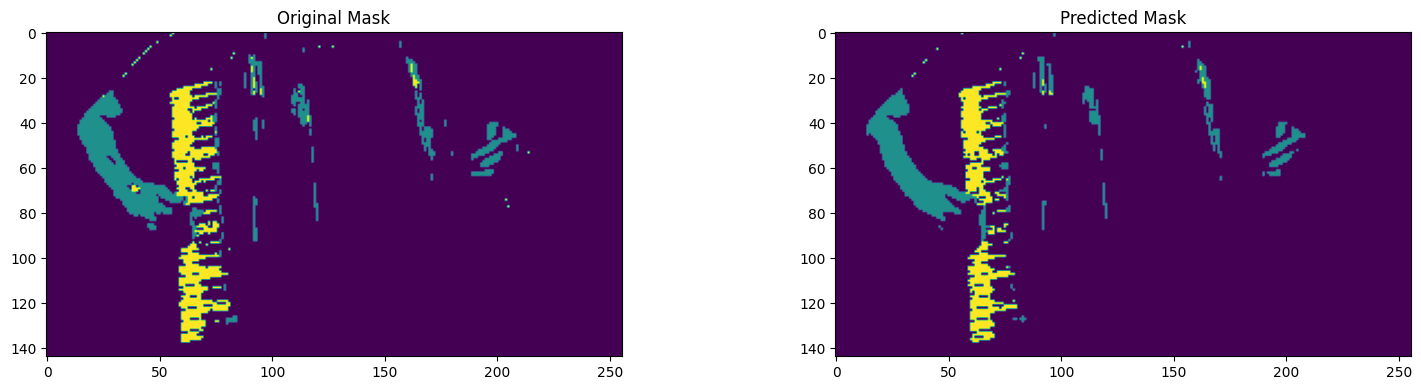

60/60 [==============================] - 43s 721ms/step - loss: 0.0168 - accuracy: 0.9933 - mean_iou: 0.9558 - val_loss: 0.0221 - val_accuracy: 0.9914 - val_mean_iou: 0.9475
Epoch 43/1000
60/60 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9931 - mean_iou: 0.9549

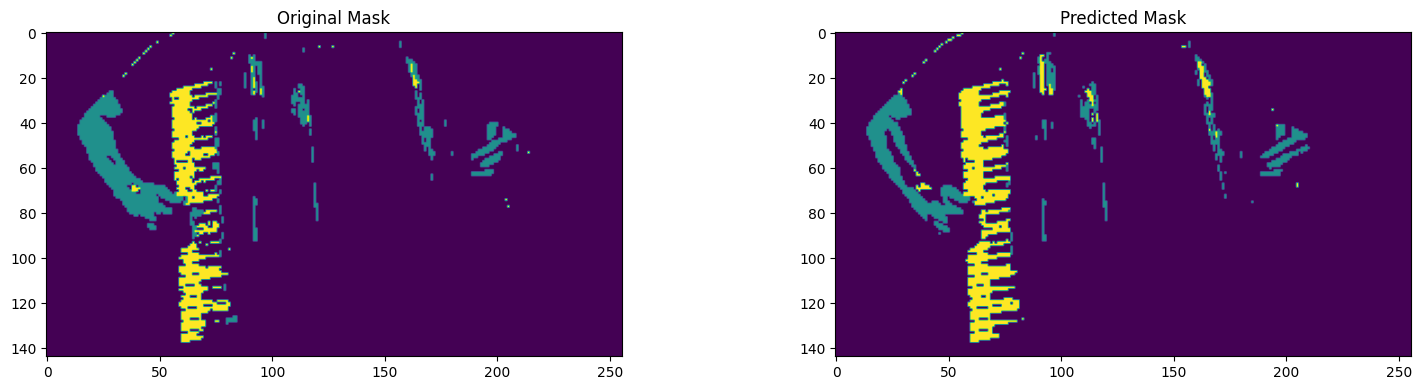

60/60 [==============================] - 43s 720ms/step - loss: 0.0171 - accuracy: 0.9931 - mean_iou: 0.9549 - val_loss: 0.0265 - val_accuracy: 0.9901 - val_mean_iou: 0.9355
Epoch 44/1000
60/60 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9933 - mean_iou: 0.9560

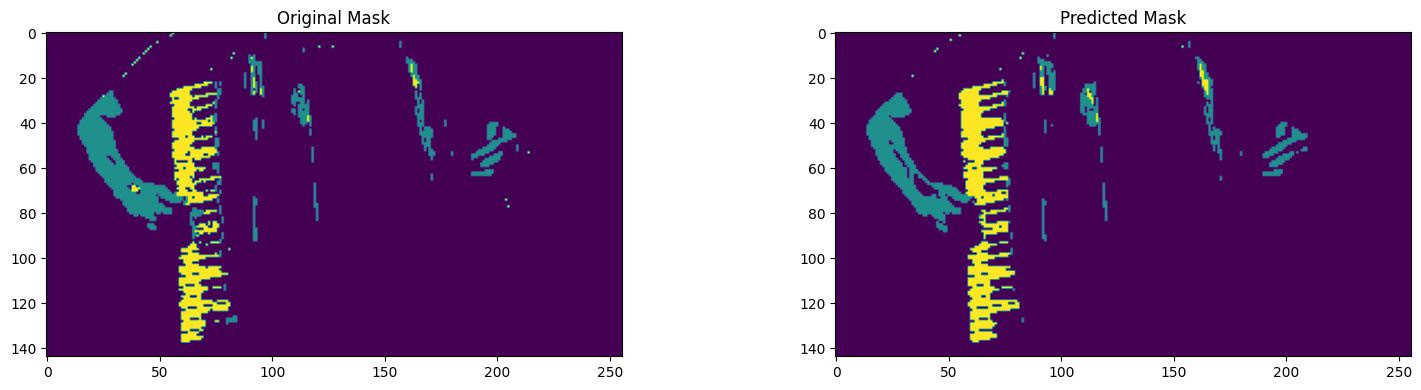

60/60 [==============================] - 43s 719ms/step - loss: 0.0166 - accuracy: 0.9933 - mean_iou: 0.9560 - val_loss: 0.0184 - val_accuracy: 0.9928 - val_mean_iou: 0.9544
Epoch 45/1000
60/60 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9935 - mean_iou: 0.9575

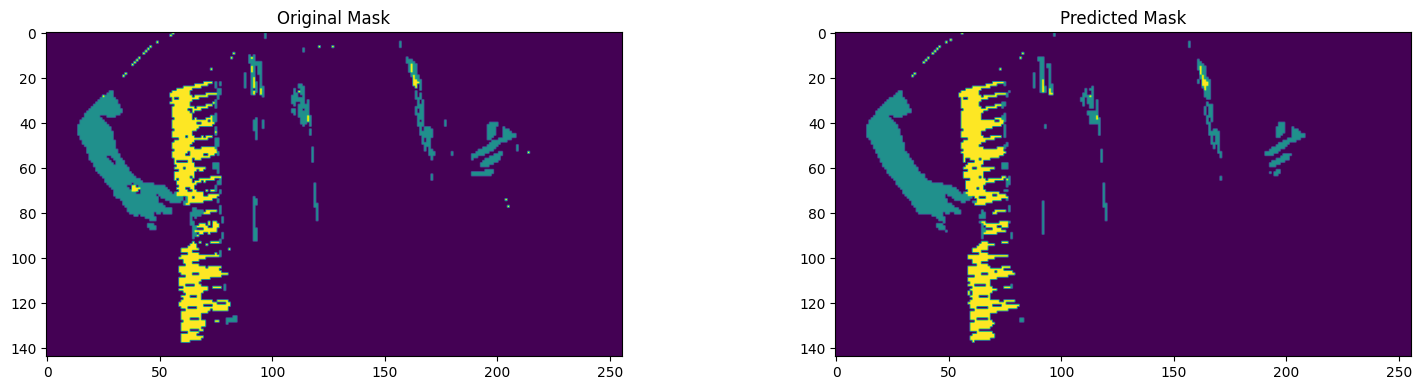

60/60 [==============================] - 43s 721ms/step - loss: 0.0161 - accuracy: 0.9935 - mean_iou: 0.9575 - val_loss: 0.0179 - val_accuracy: 0.9929 - val_mean_iou: 0.9553
Epoch 46/1000
60/60 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9930 - mean_iou: 0.9544

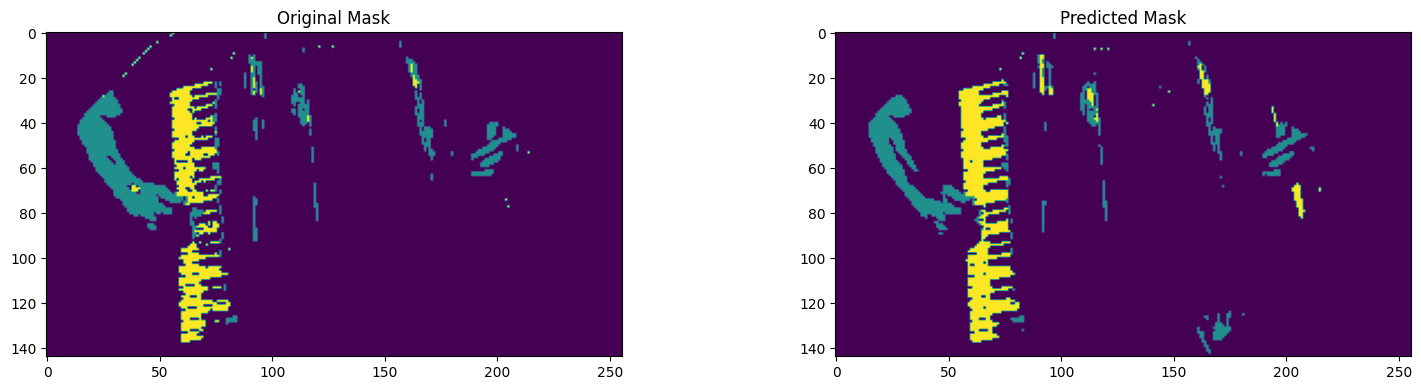

60/60 [==============================] - 43s 725ms/step - loss: 0.0174 - accuracy: 0.9930 - mean_iou: 0.9544 - val_loss: 0.0272 - val_accuracy: 0.9899 - val_mean_iou: 0.9400
Epoch 47/1000
60/60 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9592 - mean_iou: 0.7615

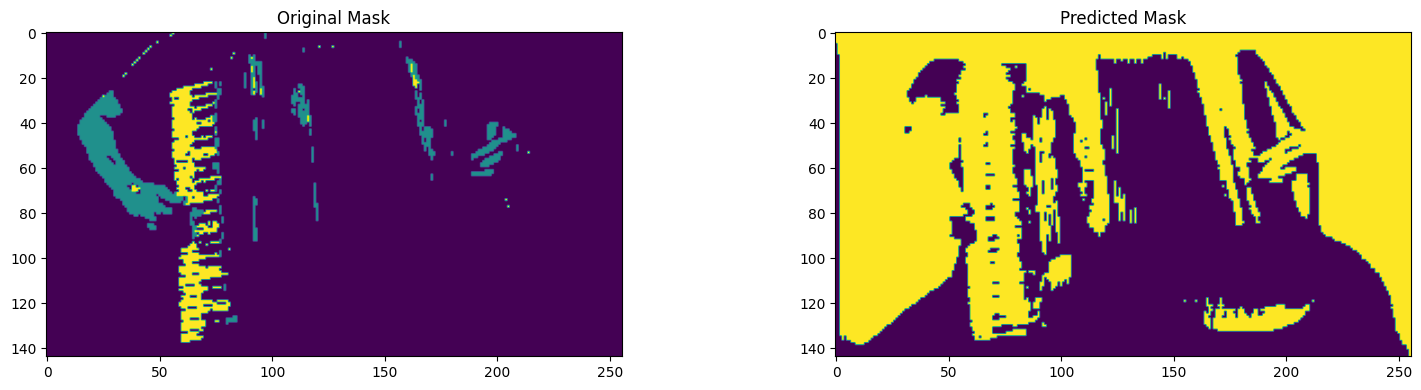

60/60 [==============================] - 43s 716ms/step - loss: 0.1179 - accuracy: 0.9592 - mean_iou: 0.7615 - val_loss: 8.0953 - val_accuracy: 0.5776 - val_mean_iou: 0.2381
Epoch 48/1000
60/60 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9770 - mean_iou: 0.8596

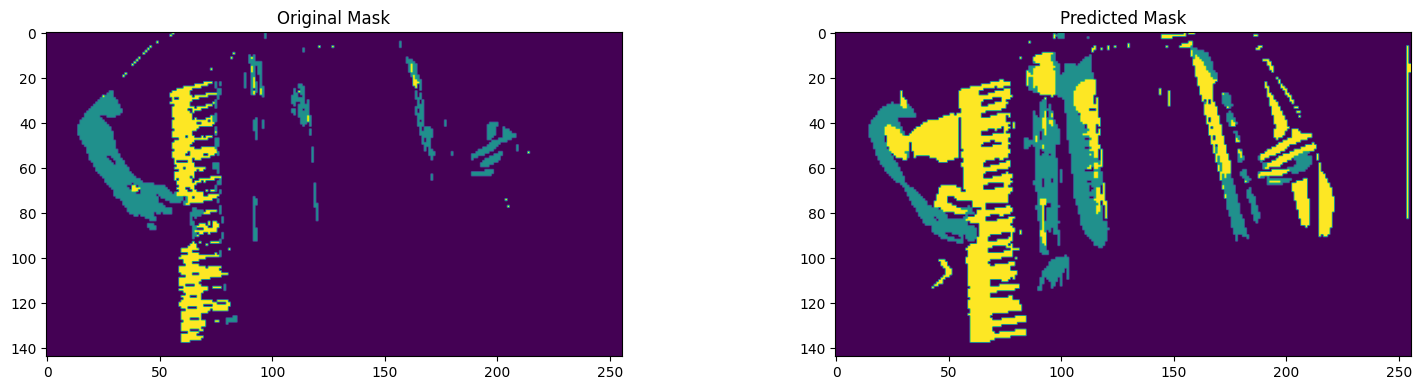

60/60 [==============================] - 43s 718ms/step - loss: 0.0641 - accuracy: 0.9770 - mean_iou: 0.8596 - val_loss: 0.2343 - val_accuracy: 0.9197 - val_mean_iou: 0.6406
Epoch 49/1000
60/60 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9835 - mean_iou: 0.8969

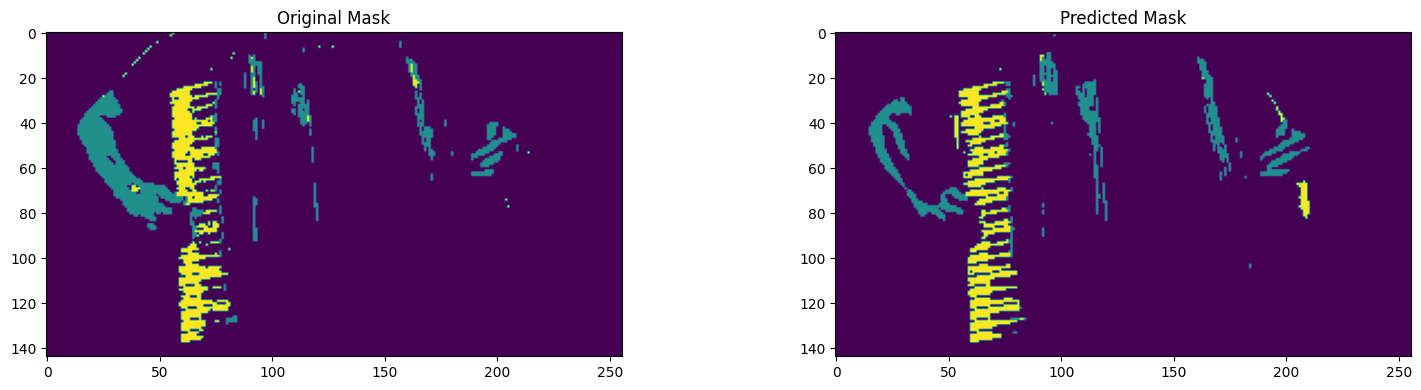

60/60 [==============================] - 43s 719ms/step - loss: 0.0450 - accuracy: 0.9835 - mean_iou: 0.8969 - val_loss: 0.0822 - val_accuracy: 0.9706 - val_mean_iou: 0.8199
Epoch 50/1000
60/60 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9859 - mean_iou: 0.9112

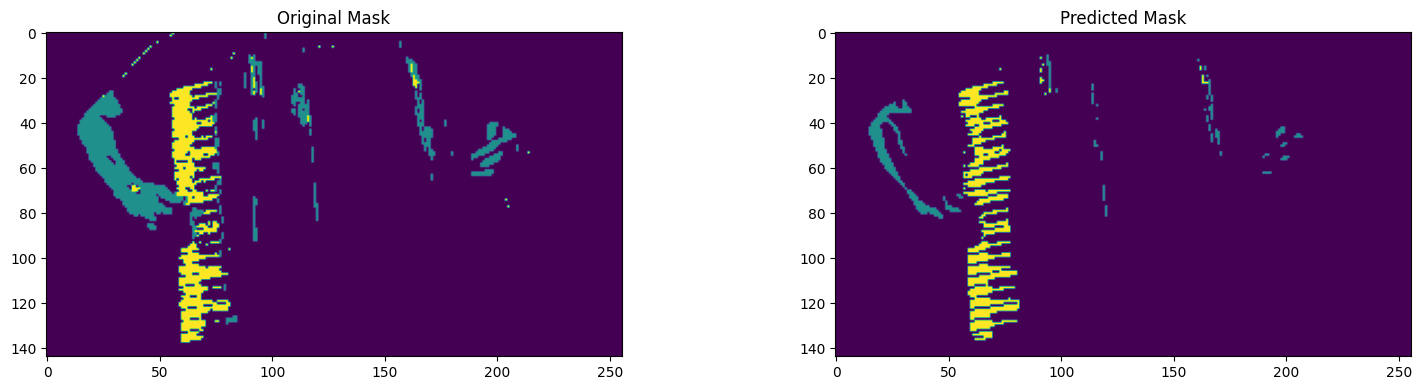

60/60 [==============================] - 43s 719ms/step - loss: 0.0380 - accuracy: 0.9859 - mean_iou: 0.9112 - val_loss: 0.1032 - val_accuracy: 0.9598 - val_mean_iou: 0.7570
Epoch 51/1000
60/60 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9873 - mean_iou: 0.9193

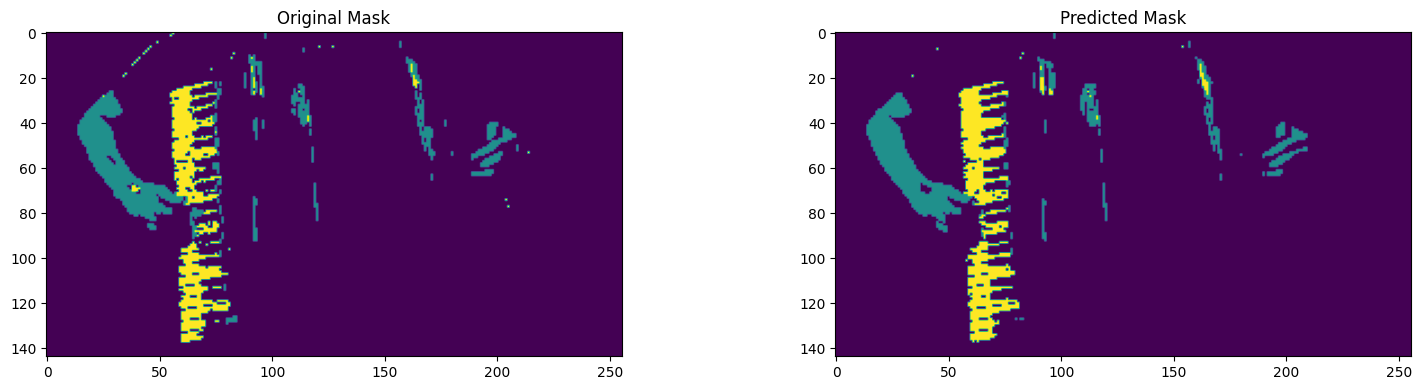

60/60 [==============================] - 43s 719ms/step - loss: 0.0338 - accuracy: 0.9873 - mean_iou: 0.9193 - val_loss: 0.0541 - val_accuracy: 0.9778 - val_mean_iou: 0.8767


In [25]:
history = model.fit(
    x=X_train, 
    y=y_train, 
    epochs = epochs, 
    batch_size = batch_size, 
    validation_data = (X_val, y_val), 
    callbacks=[early_stopping, viz_callback],
    verbose=1
)

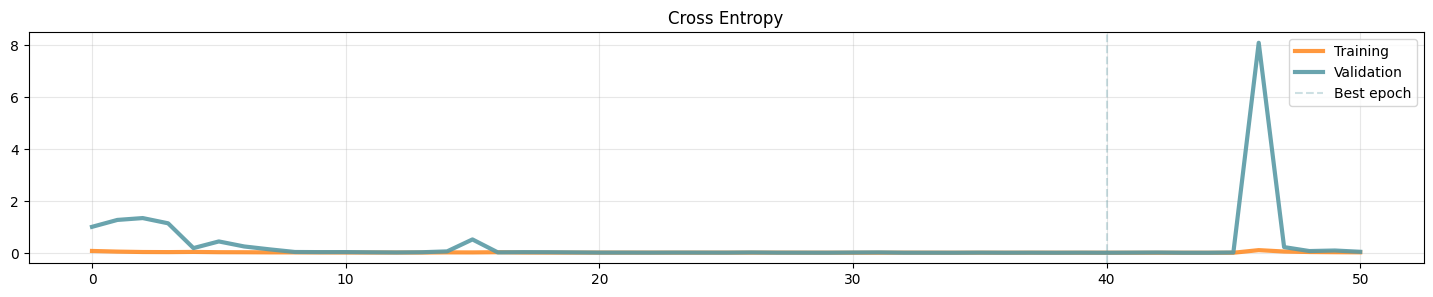

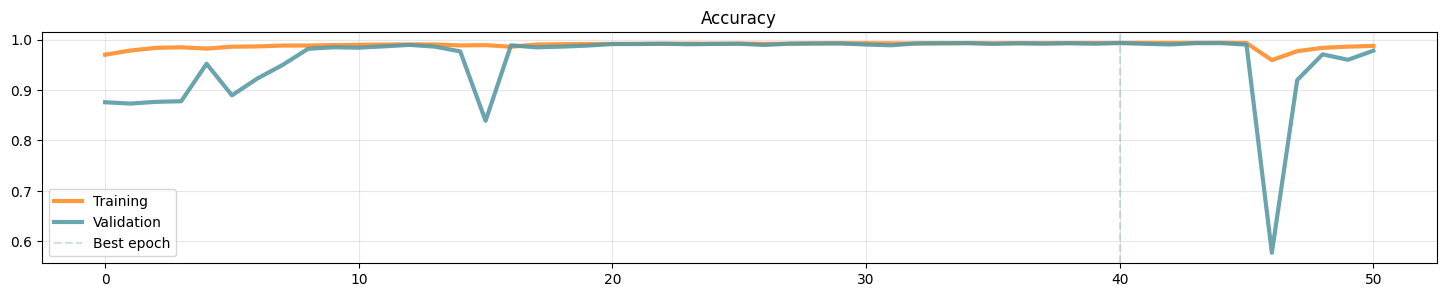

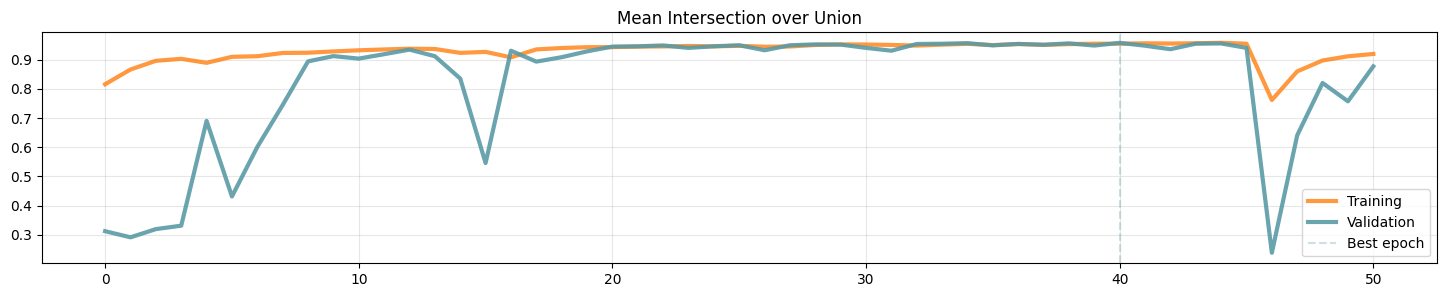

In [27]:
best_epoch = np.argmax(history.history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [28]:
model.save('UNet_3_classes')

In [54]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "num_classes": self.num_classes}

model = tfk.models.load_model('UNet_3_classes', custom_objects={'UpdatedMeanIoU': tf.keras.metrics.MeanIoU})

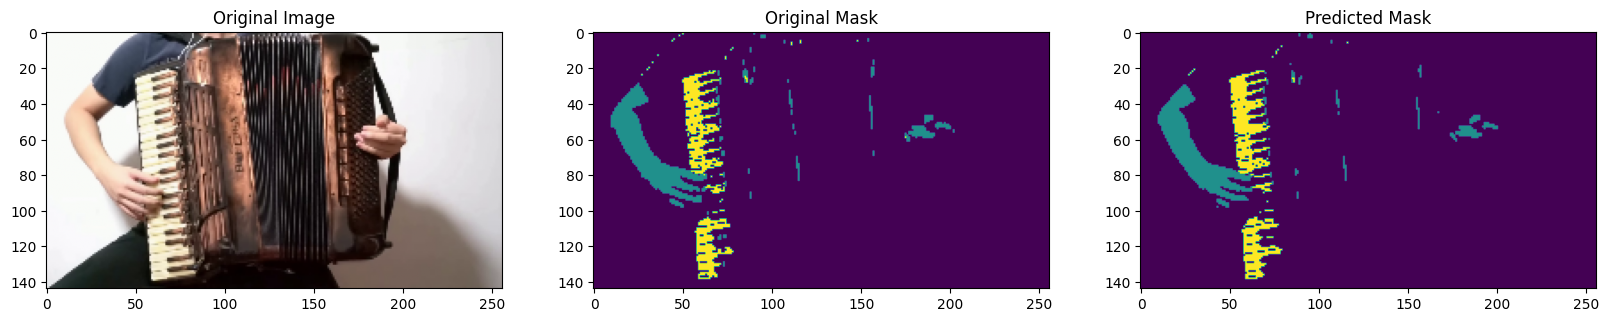

error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x39480f9d::Set<1,-1,-1>,struct cv::impl::A0x39480f9d::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [83]:
def plot_triptychs(data, labels, index=None):
    if index == None:
        index = np.random.randint(0,len(data))
    pred = model.predict(np.expand_dims(data[index], axis=0), verbose=0)
    pred = np.array(tf.math.argmax(pred, axis=-1))
    pred = np.reshape(pred, (144, 256, 1))
    fig, axes = plt.subplots(1, 3, figsize=(20,4))
    axes[0].set_title("Original Image")
    axes[0].imshow(data[index])
    axes[1].set_title("Original Mask")
    axes[1].imshow(np.squeeze(labels[index]))
    axes[2].set_title("Predicted Mask")
    axes[2].imshow(np.squeeze(pred))
    plt.show()

    test = cv2.cvtColor(data[index], cv2.COLOR_RGB2GRAY)
    plt.imshow(test)
plot_triptychs(X_val,y_val)
#plot_triptychs(X_val,y_val)
#plot_triptychs(X_val,y_val)

In [62]:
test = tfk.models.load_model('UNet', custom_objects={'UpdatedMeanIoU': tf.keras.metrics.MeanIoU})

'\nris = np.zeros(img.shape[0:2])\nx = 256\nwhile x < 1920:\n    y = 144\n    while y < 1080:\n        print(str(x)+"-"+str(y))\n        crop = img[y-144:y,x-256:x]\n        pred = test.predict(np.expand_dims(crop, axis=0), verbose=0)\n        pred = np.array(tf.math.argmax(pred, axis=-1))\n        pred = np.reshape(pred, (144, 256))\n        ris[y-144:y,x-256:x] = pred\n        y += 144\n    x += 256\nplt.imshow(ris)\n'

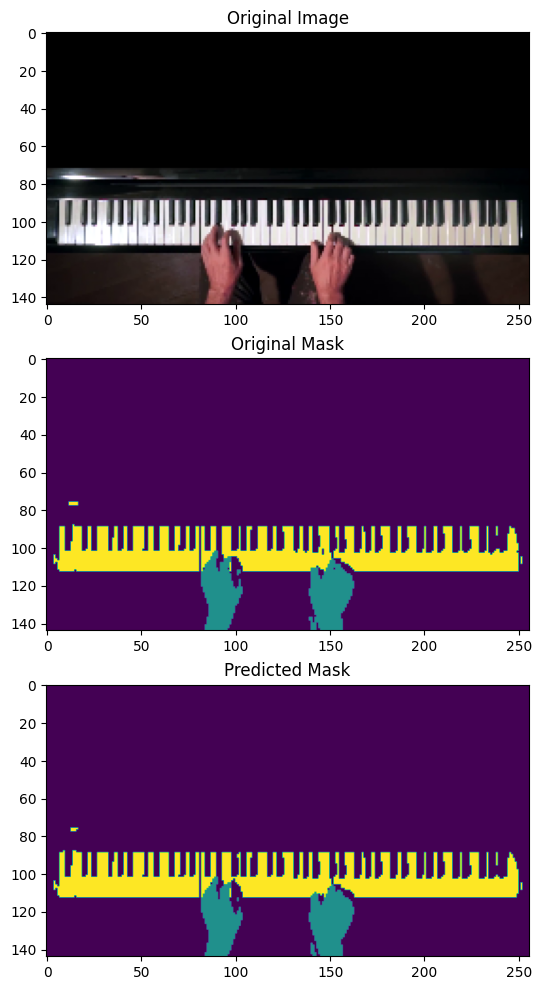

In [73]:
file = "piano_bolero__960.0.png"
img = np.array(Image.open("training_data/"+file))
'''
'''
resized = cv2.resize(img, (256, 144)) / 255.
pred = test.predict(np.expand_dims(resized, axis=0), verbose=0)
pred = np.array(tf.math.argmax(pred, axis=-1))
pred = np.reshape(pred, (144, 256, 1))
pred[pred == 0] = 0
pred[pred == 1] = 128
pred[pred == 2] = 255

or_mask = np.array(Image.open('processed_training_labels/'+file))

fig, axes = plt.subplots(3, 1, figsize=(16,12))
axes[0].set_title("Original Image")
axes[0].imshow(resized)
axes[1].set_title("Original Mask")
axes[1].imshow(or_mask)
axes[2].set_title("Predicted Mask")
axes[2].imshow(np.squeeze(pred))


'''
ris = np.zeros(img.shape[0:2])
x = 256
while x < 1920:
    y = 144
    while y < 1080:
        print(str(x)+"-"+str(y))
        crop = img[y-144:y,x-256:x]
        pred = test.predict(np.expand_dims(crop, axis=0), verbose=0)
        pred = np.array(tf.math.argmax(pred, axis=-1))
        pred = np.reshape(pred, (144, 256))
        ris[y-144:y,x-256:x] = pred
        y += 144
    x += 256
plt.imshow(ris)
'''
